In [695]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Moneyball: A Supervised Learning Approach to Baseball

This analysis is based on the film "Moneyball (2011)" which is a documentary on the Oakland A's 2002 season. In 2002, the Oakland A's made an upset when they made it to the playoffs despite losing their key players and working with a budget significantly smaller than the average baseball team franchise at that time period. Not only did the Oakland A's make the playoffs, but they also set an American League record by winning 20 consecutive games. The head GM, Billy Beane, and his assistant at the time, Paul DePodesta, attribute their success to applying Bill James's Sabermetrics to their team draft and offensive line-up. 


The goal of this analysis is to use supervised learning models to predict 2002 baseball runs allowed (RA), runs scored (RS), and wins (W) using 1962-2001 baseball statistics. We will be comparing the different supervised learning models' 2002 predictions to the Oakland A's RS, RA, & W statistics for 2002 to see how accurate the models perform. 

The data is sourced from Kaggle (https://www.kaggle.com/wduckett/moneyball-mlb-stats-19622012/data) and the preprocess step is done in a different notebook. The prepreprocess notebook is imported as "preprocess_data.py".

## Pythagorean Expectation Formula (Sabermetrics)

DePodesta utilized the Pythagorean Expectation Formula, a sabermetric formula that is designed to estimate the number of wins a baseball team should win based on the number of runs they scored (RS) and allowed (RA). A team wins if RS is higher than the opposite team's RS. 

In [592]:
%%latex
$$Win\,Ratio = \frac{(Runs\,Scored)^2}{(Runs\,Scored)^2 + (Runs\,Allowed)^2}$$

<IPython.core.display.Latex object>

## The Big Question, "How many games to win in order to make the playoffs?"

A baseball team needs to play 162 games before the playoff season. DePodesta predicted that the Oakland A's would need to win about 99 games to confidently secure a spot in the playoffs. Let's see if his prediction is accurate...

In [593]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import preprocess_data
plt.style.use("seaborn")
%matplotlib inline

In [594]:
# read in preprocessed data
data = preprocess_data.df3
data.head(3)

,RS,RA,W,OBP,SLG,BA,OOBP,OSLG,Year,Team,RD
300,851,644,99,0.341,0.433,0.282,0.314,0.392,2002,ANA,207
301,819,674,98,0.346,0.423,0.267,0.305,0.397,2002,ARI,145
302,708,565,101,0.331,0.409,0.260,0.313,0.364,2002,ATL,143


In [595]:
# split dataset into pre- and post- 2002 datasets, for comparative analysis later
pre_2002 = data[data["Year"]<2002]
post_2002 = data[data["Year"]==2002]

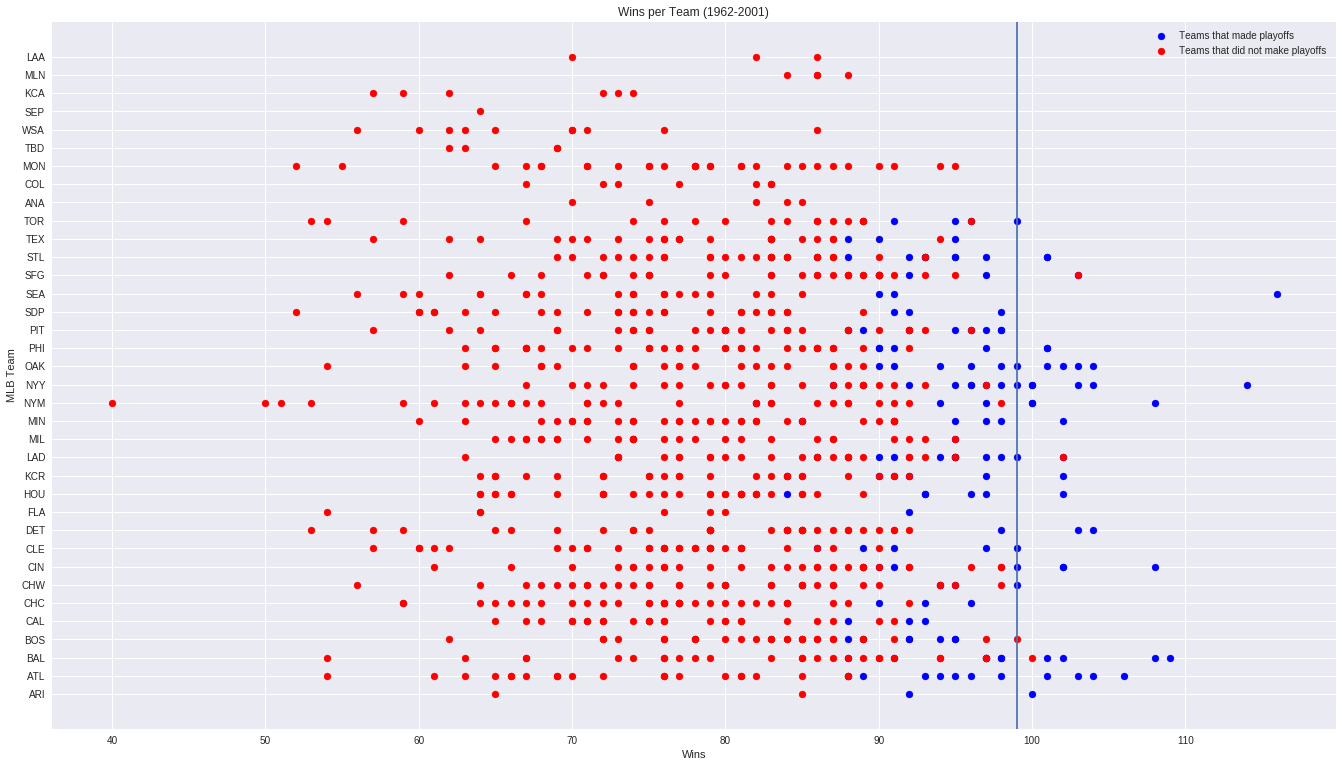

In [596]:
# visualizing DePodesta's win estimation
mb_data = preprocess_data.df_copy
mb_data = mb_data[mb_data["Year"]<2002]
plt.rcParams['figure.figsize'] = (23,13)
mb_made_playoffs = mb_data[mb_data["Playoffs"]==1]
mb_no_playoffs = mb_data[mb_data["Playoffs"]==0]

plt.scatter(mb_made_playoffs["W"],mb_made_playoffs["Team"],color="blue",label="Teams that made playoffs")
plt.scatter(mb_no_playoffs["W"],mb_no_playoffs["Team"],color="red",label="Teams that did not make playoffs")
plt.axvline(x=99)
plt.title("Wins per Team (1962-2001)")
plt.xlabel("Wins")
plt.ylabel("MLB Team")
plt.legend()
plt.show()

In [597]:
# check the seasons where a team had more than 99 wins and did not make playoffs 
mb_po = mb_data[(mb_data["W"]>=99)&(mb_data["Playoffs"]==0)]
print("Years: ",mb_po["Year"])
print("Teams: ",mb_po["Team"])

Years:  530     1993
821     1980
874     1978
1222    1962
Name: Year, dtype: int64
Teams:  530     SFG
821     BAL
874     BOS
1222    LAD
Name: Team, dtype: object


The graph shows the number of teams that made it to the playoffs after playing 162 games between 1962-2001. The vertical line represents DePodesta's 99 win estimation. The estimation appears to be fairly accurate with only 3 teams not being able to make playoffs after 99 wins. It also looks like these 3 outliers appear to be centered in years pre-1990, which might indicate different standards for playoff qualifications. Therefore, it is safe to conclude that 99 wins is a safe cutoff point for a guaranteed spot in the playoffs.

## Using pythagorean expectation formula to estimate RS & RA

Using DePodesta's win estimate to find the win ratio (out of 162 games).

In [598]:
%%latex
$$\frac{99\,wins}{162\,games} = 0.61\,win\,ratio$$

<IPython.core.display.Latex object>

Finding RS & RA using pythagorean expectation formula.

In [599]:
%%latex
$$\frac{(814)^2}{(814)^2+(645)^2} = 0.6143$$

<IPython.core.display.Latex object>

DePodesta's estimates for the Oakland A's making playoffs in 2002 season:

1. Runs Scored (RS): 814
2. Runs Allowed (RA): 645
3. Wins (W): 99

## Other key baseball terminology for analysis:

On-Base Percentage (OBP): measures how frequently a batter reaches base

Slugging Percentage (SLG): measures the batting productivity of a batter

Batting Average (BA): measures the performance of a batter 

Opponent's On-Base Percentage & Slugging Percentage (OOBP & OSLG): same as OBP & SLG except for opponents

Run Differential (RD): combines offensive & defensive scoring (RS - RA) 

In [600]:
%%latex
$$Runs\,Differential\,(RD) = Runs\,Scored(RS)-Runs\,Allowed(RA)$$

<IPython.core.display.Latex object>

In [601]:
%%latex
$$On\,Base\,Percentage\,(OBP\,or\,OOBP) = \frac{Hits(H)+Walks(BB)+HitByPitch(HBP)}{AtBat(AB)+Walks(BB)+HitByPitch(HBP)+SacrificeFly(SF)}$$

<IPython.core.display.Latex object>

In [602]:
%%latex
$$Slugging\,Percentage\,(SLG\,or\,OSLG) = \frac{Single(1B) + (2*Double(2B)) + (3*Triple(3B)) + (4*HomeRun(HR))}{AtBat(AB)}$$

<IPython.core.display.Latex object>

In [603]:
%%latex
$$Batting\,Average\,(BA) = \frac{Hits(H)}{AtBat(AB)}$$

<IPython.core.display.Latex object>

## Feature Engineering (RS, RA, W)

The target features for this analysis are:

1. Runs Scored (RS)

2. Runs Allowed (RA)

3. Wins (W)

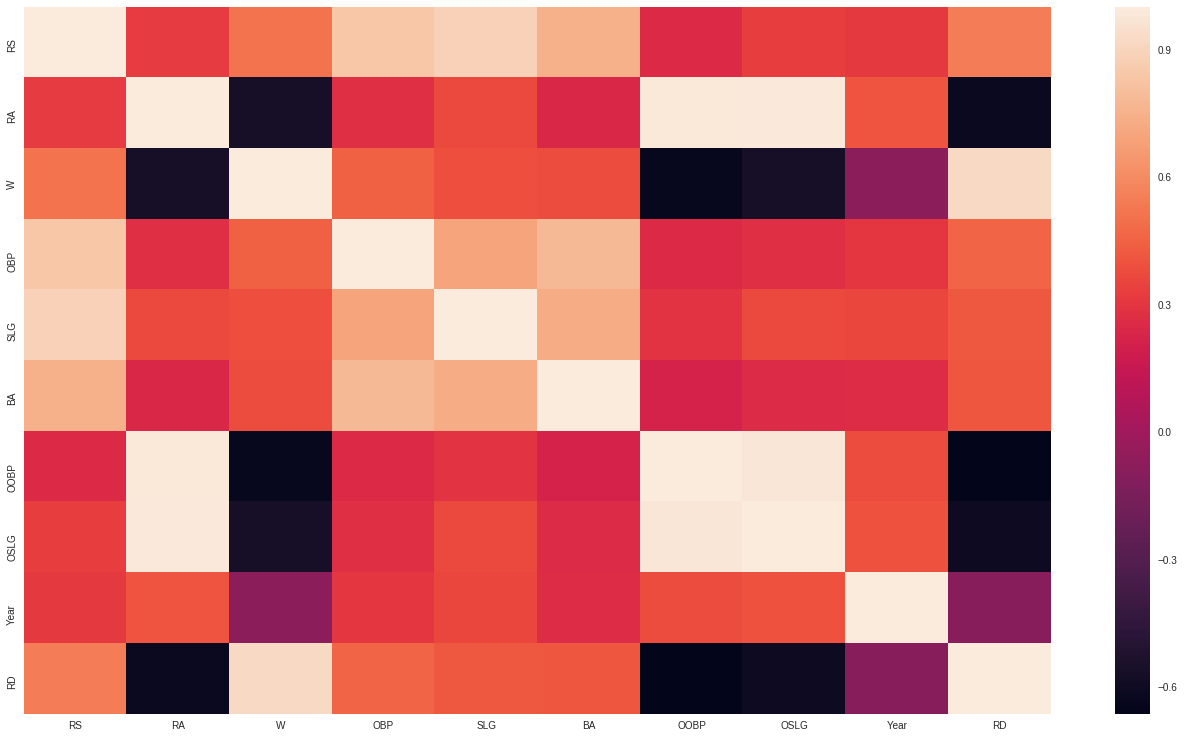

In [604]:
# use correlation matrix to find features most correlated with the target features
corrmat = pre_2002.corr()
sns.heatmap(corrmat)
plt.show()

We are looking for features that have a strong positive correlation with our desired target variables (between 0.75 to 0.9). 

Here's the breakdown based on the correlation matrix:
1. Runs Allowed (RA) : Opponent's On-Base Percentage (OOBP), Opponent's Slugging Percentage (OSLG)

2. Runs Scored (RS) : On-Base Percentage (OBP), Slugging Percentage (SLG), Batting Average (BA)

3. Wins (W): Run Differential (RD)

## Multivariate Linear Regression

Temporarility disregard linear regression assumption "multicollinearity" because the primary goal of the analysis is prediction, and, therefore, we are only concerned that the variance gets explained and not which features matter the most when predicting the outcome.

In [605]:
# functions for plotting and linear regression assumptions

# graphing function for plotting linear relationship between features and target variable
def plot_scatter(X,y,y_axis_title,n_columns):
    fig,ax = plt.subplots(nrows=1,ncols=n_columns)
    y_ax = 0
    
    for col in X.columns:
        x_sort = X[col].values
        y_sort = y.values
        ax[y_ax].scatter(x_sort,y_sort)
        ax[y_ax].set_ylabel(y_axis_title)
        ax[y_ax].set_xlabel("{}".format(col))
        y_ax += 1
        
    fig.tight_layout()
    plt.show()

# function for determining multivariate normality & homoscedasticity
def multi_norm_homo(X,y,regr_model,n_columns):
    actual = y
    # fit full X features dataset into prediction (not test dataset)
    predicted = regr_model.predict(X)
    residual = actual - predicted
    
    plt.rcParams["figure.figsize"] = (12,6)
    fig,ax = plt.subplots(nrows=1,ncols=n_columns)
    
    ax[0].hist(residual)
    ax[0].set_title("Multivariate Normality (Residual Counts)")
    ax[0].set_xlabel("Residual")
    ax[0].set_ylabel("Count")
    
    ax[1].scatter(predicted,residual)
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Residual")
    ax[1].axhline(y=0)
    ax[1].set_title("Homoscedasticity (Residual vs. Predicted)")
    
    fig.tight_layout()
    plt.show()

### Runs Scored (RS)

In [606]:
# establish features and target variables
X_RS = pre_2002[["OBP","SLG","BA"]]
y_RS = pre_2002["RS"]

#### Linear Assumption: Linear Relationship (RS vs OBP, SLG & BA)

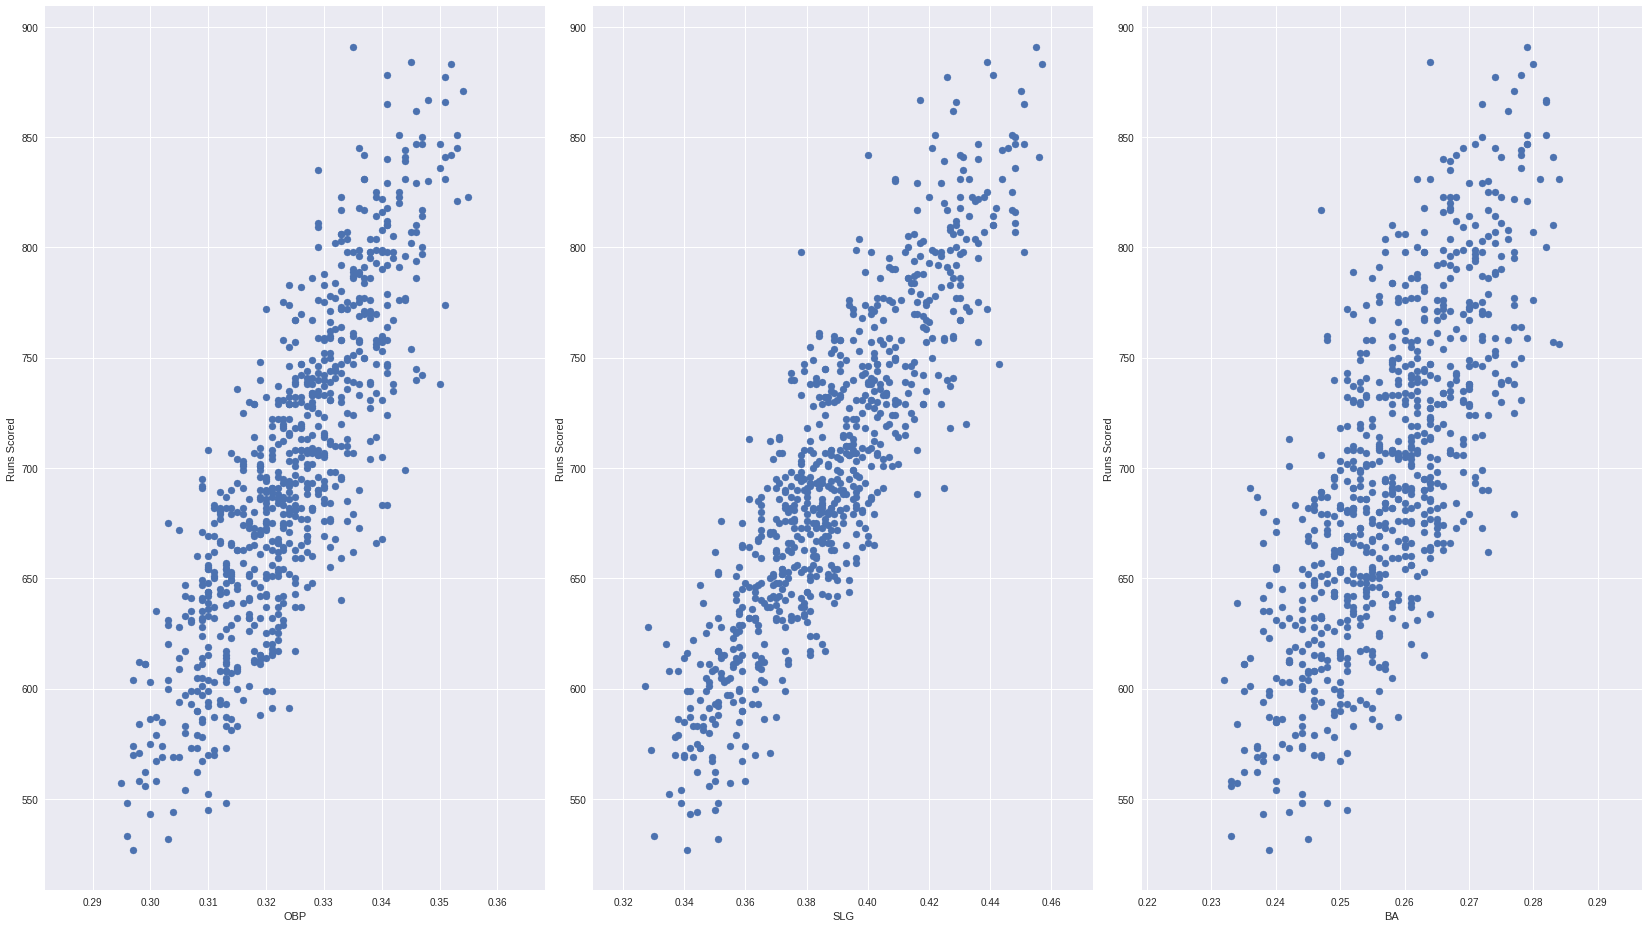

In [607]:
# linear regression assumption #1: linear relationship between dependent (RS) & independent features (OBP,SLG,BA)
plot_scatter(X_RS,y_RS,"Runs Scored",3)

There appears to be a strong linear relationship between independent features and dependent variable. 

In [608]:
# train & test set for RS (80 train : 20 test split)
from sklearn.model_selection import train_test_split
XRS_train,XRS_test,yRS_train,yRS_test = train_test_split(X_RS,y_RS,test_size=0.2,random_state=42)

In [609]:
# fit linear regression to RS dataset
from sklearn.linear_model import LinearRegression
regr_RS = LinearRegression()
regr_RS.fit(XRS_train,yRS_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Linear Assumptions: Multivariate Normality & Homoscedasticity (RS)

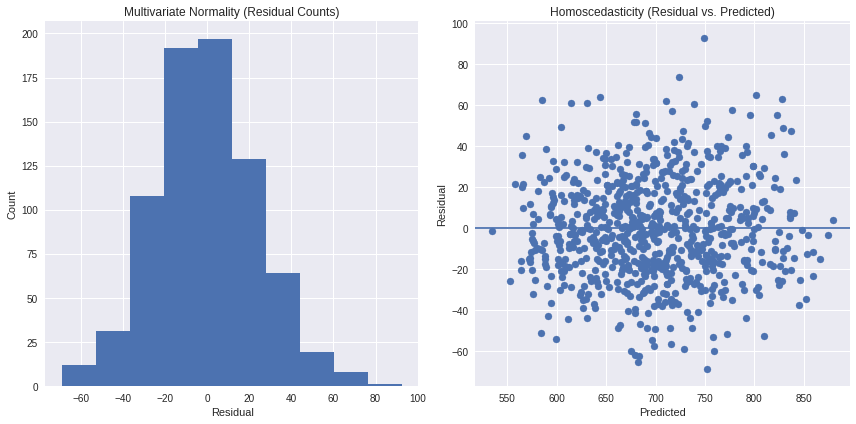

In [610]:
multi_norm_homo(X_RS,y_RS,regr_RS,2)

The error from the model looks normally distributed and the distribution of the error terms looks consistent between small & large values. 

#### Evaluating model performance for RS

In [611]:
# evaluating model performance (RS)
print("Coefficients:\n",regr_RS.coef_)
print("\nIntercept:\n",regr_RS.intercept_)
print("\nR-squared:\n",regr_RS.score(XRS_test,yRS_test))

Coefficients:
 [2818.77404377 1623.85784111 -421.32174994]

Intercept:
 -737.3350060997697

R-squared:
 0.886601225683632


The coefficient for BA is counterintuitive. A player's Runs Scored should improve as their Batting Average improves, but the negative coefficient shows the opposite relationship. This may be due to multicollinearity, and we'll try to remove BA after applying cross validation to the model to check for possible overfitting. 

In [612]:
# evaluating model using cross validation (RS)
from sklearn.model_selection import cross_val_score
cvs_RS = cross_val_score(estimator=regr_RS,X=X_RS,y=y_RS,cv=10)
print(cvs_RS)

[0.86535779 0.84744611 0.80942664 0.86304231 0.85538966 0.88536053
 0.90428955 0.84230533 0.90618462 0.8472854 ]


#### Testing parameters, remove features with p-values > 0.01

Double checking the parameters to see if BA is a significant feature for the model by comparing p-values between independent features and dependent variable.

In [613]:
# testing individual parameters
import statsmodels.formula.api as sm
linear_formula_RS = 'RS ~ OBP + SLG + BA'
lm_RS = sm.ols(formula=linear_formula_RS,data=pre_2002).fit()

In [614]:
# check p-values for features and target variable, if p-value > 0.01 drop feature
lm_RS.pvalues

Intercept    2.662364e-130
OBP           1.296124e-87
SLG          8.965283e-144
BA            2.151727e-02
dtype: float64

Decided to set the threshold to 0.01 because most features displayed p-values significantly less than 0.05. We find that the Batting Average has a p-value significantly greater than the other features and greater than the 0.01 threshold. We are going to try dropping BA, refit the regression model, and check if the accuracy improves.

In [615]:
# remove BA, retrain & refit model
X_RS = pre_2002[["OBP","SLG"]]
XRS_train,XRS_test,yRS_train,yRS_test = train_test_split(X_RS,y_RS,test_size=0.2,random_state=42)
regr_RS.fit(XRS_train,yRS_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [616]:
# evaluating model performance (RS)
print("Coefficients:\n",regr_RS.coef_)
print("\nIntercept:\n",regr_RS.intercept_)
print("\nR-squared:\n",regr_RS.score(XRS_test,yRS_test))
LinR2_RS = regr_RS.score(XRS_test,yRS_test)

Coefficients:
 [2603.06540148 1567.19559227]

Intercept:
 -754.0865717363041

R-squared:
 0.888040611042025


In [617]:
cvs_RS = cross_val_score(estimator=regr_RS,X=X_RS,y=y_RS,cv=10)
print("Cross-validation: ",cvs_RS)

Cross-validation:  [0.87079743 0.84803503 0.80515307 0.86227821 0.8559369  0.88224901
 0.90349773 0.84088214 0.90309005 0.84835513]


It appears that removing BA did not negatively impact the model. Will permanently remove BA for the remainder of the analysis.

### Runs Allowed (RA)

In the preprocessing step, we needed to impute 814 missing data values for OOBP and OSLG. We decided to use a regression strategy for imputing the missing values. This could cause some slight overfitting in the model because the data will be almost perfectly linear.

In [618]:
X_RA = pre_2002[["OOBP","OSLG"]]
y_RA = pre_2002["RA"]

#### Linear Assumption: Linear Relationship (RA vs OOBP & OSLG)

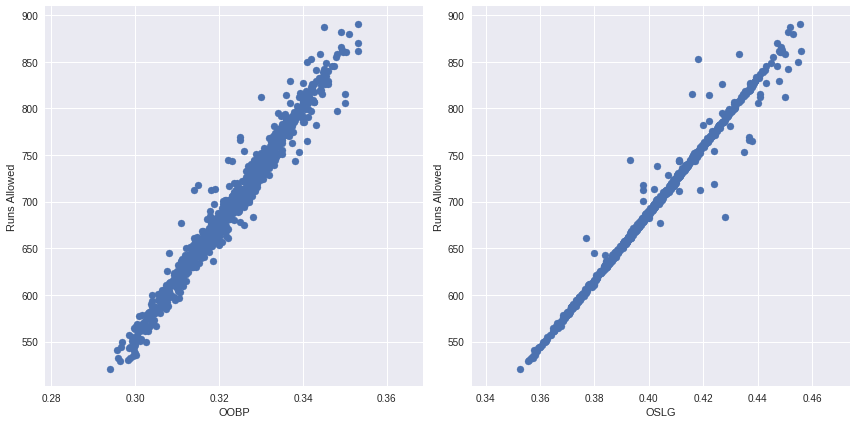

In [619]:
plot_scatter(X_RA,y_RA,"Runs Allowed",2)

As the graph shows, there is a very strong linear relationship between the independent features and the dependent variable. This is probably due to the method of imputing the missing data during the preprocessing phase.

In [620]:
# create train & test set for RA
XRA_train,XRA_test,yRA_train,yRA_test = train_test_split(X_RA,y_RA,test_size=0.2,random_state=42)

In [621]:
# fit linear regression to RA dataset
regr_RA = LinearRegression()
regr_RA.fit(XRA_train,yRA_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Linear Assumptions: Multivariate Normality & Homoscedasticity (RA)

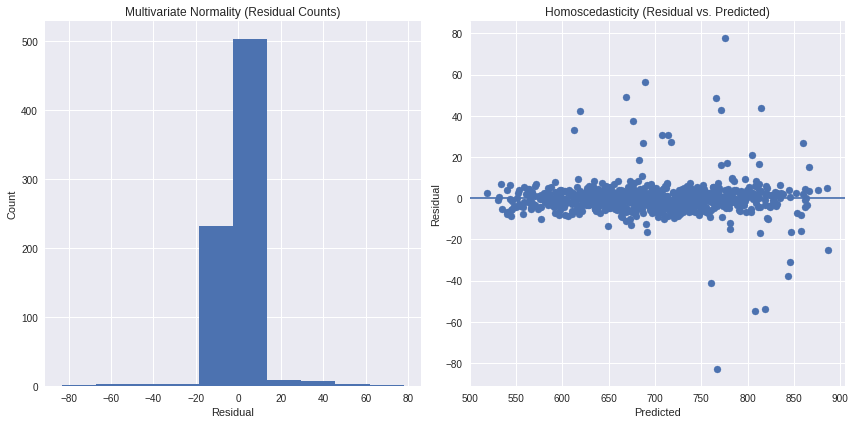

In [622]:
# checking for multivariate normality & homoscedasticity
multi_norm_homo(X_RA,y_RA,regr_RA,2)

The error from the model looks normally distributed with a large concentration of small errors. The distribution of the error terms looks consistent between small & large values with a few outlier points around the larger values, which are probably related to the values that were not artificially inputed. 

#### Evaluating model performance for RA

In [623]:
# evaluating model performance (RA)
print("Coefficients:\n",regr_RA.coef_)
print("\nIntercept:\n",regr_RA.intercept_)
print("\nR-squared:\n",regr_RA.score(XRA_test,yRA_test))
LinR2_RA = regr_RA.score(XRA_test,yRA_test)

Coefficients:
 [2229.42946165 2299.5091078 ]

Intercept:
 -948.4469909527586

R-squared:
 0.9887271671142125


In [624]:
# evaluating model performance with cross validation
cvs_RA = cross_val_score(estimator=regr_RA,X=X_RA,y=y_RA,cv=10)
print("Cross-validation: ",cvs_RA)

Cross-validation:  [0.761377   0.99736116 0.99660169 0.9976516  0.99702145 0.99601811
 0.99544181 0.99557353 0.99763524 0.99627014]


The R-squared value is extrememly high and there appears to be some fluctuation present in the cross-validation scores. These indicate slight overfitting in the RA model.

#### Testing parameters, remove features with p-values > 0.01

In [625]:
# test individual parameters
linear_formula = 'RA ~ OOBP + OSLG'
lm = sm.ols(formula=linear_formula,data=pre_2002).fit()

In [626]:
lm.pvalues

Intercept     0.000000e+00
OOBP          6.241072e-55
OSLG         3.050347e-147
dtype: float64

### Wins (W)

In [627]:
X_W = pre_2002[["RD"]]
y_W = pre_2002["W"]

#### Linear Assumption: Linear Relationship (W vs RD)

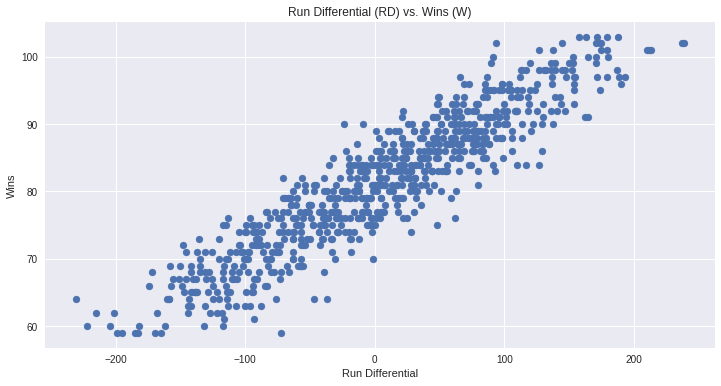

In [628]:
# visualize relationship between RD and W
x_sort = X_W.values
y_sort = y_W.values
plt.scatter(x_sort,y_sort)
plt.ylabel("Wins")
plt.xlabel("Run Differential")
plt.title("Run Differential (RD) vs. Wins (W)")
plt.show()

The graph shows a strong linear relationship between the independent feature and the dependent feature.

In [629]:
# create train & test set for W
XW_train,XW_test,yW_train,yW_test = train_test_split(X_W,y_W,test_size=0.2,random_state=42)

In [630]:
# fit linear regression to W dataset
regr_W = LinearRegression()
regr_W.fit(XW_train,yW_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Linear Assumptions: Multivariate Normality & Homoscedasticity (W)

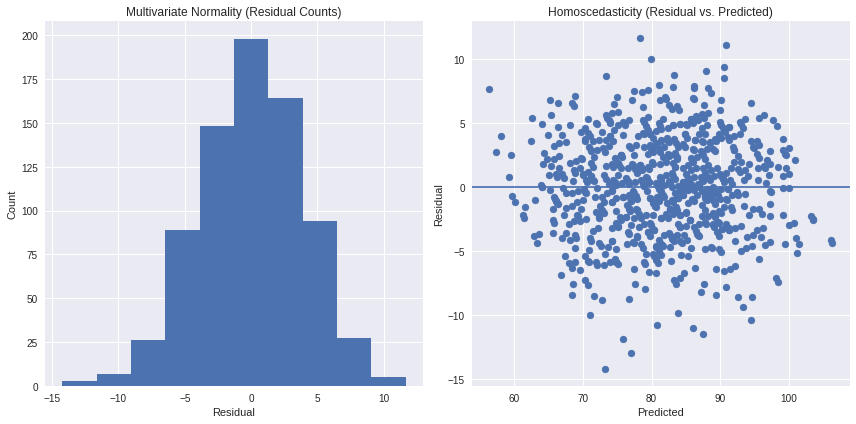

In [631]:
# checking for multivariate normality & homoscedasticity
multi_norm_homo(X_W,y_W,regr_W,2)

The error from the model looks normally distributed and the distribution of the error terms looks consistent between small & large values. 

#### Evaluating model performance for W

In [632]:
# evaluating model performance (W)
print("Coefficients:\n",regr_W.coef_)
print("\nIntercept:\n",regr_W.intercept_)
print("\nR-squared:\n",regr_W.score(XW_test,yW_test))
LinR2_W = regr_W.score(XW_test,yW_test)

Coefficients:
 [0.10642527]

Intercept:
 80.90277054378944

R-squared:
 0.8644873113682567


In [633]:
# evaluating model performance using cross-validation
cvs_W = cross_val_score(estimator=regr_W,X=X_W,y=y_W,cv=10)
print("Cross-validation: ",cvs_W)

Cross-validation:  [0.90354023 0.79905102 0.85810646 0.82809896 0.82903313 0.8578853
 0.85316979 0.82510435 0.83389087 0.85336304]


#### Testing parameters, remove features with p-values > 0.01

In [634]:
# test individual parameters
linear_formula = 'W ~ RD'
lm = sm.ols(formula=linear_formula,data=pre_2002).fit()

In [635]:
lm.pvalues

Intercept     0.000000e+00
RD           4.628305e-313
dtype: float64

In [636]:
# create a list of R2 scores for comparison between other models
LinR2 = [LinR2_RS,LinR2_RA,LinR2_W]

## Support Vector Regression

Data needs to be scaled before splitting into train/test sets and before fitting into model.

In [637]:
from sklearn.preprocessing import StandardScaler

# create function for scaling data
def scale_data(x,y):
    sc_x = StandardScaler()
    x_scale = sc_x.fit_transform(x)
    sc_y = StandardScaler()
    y_scale = sc_y.fit_transform(y.values.reshape(-1,1))
    return x_scale,y_scale,sc_y

# functions for evaluating model performance
def model_perform(xRS,xRA,xW,yRS,yRA,yW,model_RS,model_RA,model_W):
    RS = model_RS.score(xRS,yRS.ravel())
    RA = model_RA.score(xRA,yRA.ravel())
    W = model_W.score(xW,yW.ravel())
    r2_list= [RS,RA,W]
    print("RS (R^2): ",model_RS.score(xRS,yRS.ravel()))
    print("\nRA (R^2): ",model_RA.score(xRA,yRA.ravel()))
    print("\nW (R^2): ",model_W.score(xW,yW.ravel()))
    return r2_list
    
def model_cv(xRS,xRA,xW,yRS,yRA,yW,model_RS,model_RA,model_W):
    print("RS Cross Validation Score:\n",cross_val_score(model_RS,xRS,yRS.ravel(),cv=10))
    print("\nRA Cross Validation Score:\n",cross_val_score(model_RA,xRA,yRA.ravel(),cv=10))
    print("\nW Cross Validation Score:\n",cross_val_score(model_W,xW,yW.ravel(),cv=10))

In [638]:
# scale data for SVR model

# RS
sc_RSX,sc_RSy,RSysc = scale_data(X_RS,y_RS)

# RA
sc_RAX,sc_RAy,RAysc = scale_data(X_RA,y_RA)

# W
sc_WX,sc_Wy,Wysc = scale_data(X_W,y_W)

/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [639]:
# create train & test data with scaled data

# RS
XRS_sc_train,XRS_sc_test,yRS_sc_train,yRS_sc_test = train_test_split(sc_RSX,sc_RSy,test_size=0.2,random_state=42)

# RA
XRA_sc_train,XRA_sc_test,yRA_sc_train,yRA_sc_test = train_test_split(sc_RAX,sc_RAy,test_size=0.2,random_state=42)

# W
XW_sc_train,XW_sc_test,yW_sc_train,yW_sc_test = train_test_split(sc_WX,sc_Wy,test_size=0.2,random_state=42)

In [640]:
# fit SVR to datasets
from sklearn.svm import SVR

# RS
svr_RS = SVR()
svr_RS.fit(XRS_sc_train,yRS_sc_train.ravel())

# RA
svr_RA = SVR()
svr_RA.fit(XRA_sc_train,yRA_sc_train.ravel())

# W
svr_W = SVR()
svr_W.fit(XW_sc_train,yW_sc_train.ravel())

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

#### Evaluating Model Performance for SVR

In [641]:
# evaluate SVR model performance
SVR2 = model_perform(XRS_sc_test,XRA_sc_test,XW_sc_test,yRS_sc_test,yRA_sc_test,yW_sc_test,svr_RS,svr_RA,svr_W)

RS (R^2):  0.8779065544166876

RA (R^2):  0.9903915210863451

W (R^2):  0.8650692370353242


In [642]:
# evaluate SVR model performance using cross validation
model_cv(sc_RSX,sc_RAX,sc_WX,sc_RSy,sc_RAy,sc_Wy,svr_RS,svr_RA,svr_W)

RS Cross Validation Score:
 [0.85198132 0.85283564 0.81130068 0.8645448  0.84754541 0.87066129
 0.90617457 0.84932539 0.89337    0.8518528 ]

RA Cross Validation Score:
 [0.83752773 0.99521007 0.99694555 0.99689723 0.99694094 0.99548939
 0.99572326 0.99625047 0.99774972 0.99525378]

W Cross Validation Score:
 [0.90430769 0.79872516 0.85815351 0.82946288 0.82584649 0.85191211
 0.85734372 0.82265815 0.83150227 0.85146169]


## Random Forest Regression

Using 100 trees for the model...

In [643]:
from sklearn.ensemble import RandomForestRegressor

# RS
rf_regr_RS = RandomForestRegressor(n_estimators=100)
rf_regr_RS.fit(XRS_train,yRS_train)

# RA
rf_regr_RA = RandomForestRegressor(n_estimators=100)
rf_regr_RA.fit(XRA_train,yRA_train)

# W
rf_regr_W = RandomForestRegressor(n_estimators=100)
rf_regr_W.fit(XW_train,yW_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### Evaluate Model Performance for Random Forest Regression

In [644]:
# evaluate model performance
RFR2 = model_perform(XRS_test,XRA_test,XW_test,yRS_test,yRA_test,yW_test,rf_regr_RS,rf_regr_RA,rf_regr_W)

RS (R^2):  0.8588250943988559

RA (R^2):  0.9911303586841922

W (R^2):  0.808729923946163


In [645]:
# evaluate model performance via cross validation
model_cv(X_RS,X_RA,X_W,y_RS,y_RA,y_W,rf_regr_RS,rf_regr_RA,rf_regr_W)

RS Cross Validation Score:
 [0.84185329 0.80790146 0.7565305  0.81953984 0.78134653 0.8618678
 0.88815147 0.75878069 0.88286016 0.82165673]

RA Cross Validation Score:
 [0.7664787  0.99654091 0.99569385 0.99638663 0.99500473 0.99544095
 0.99791498 0.99724659 0.99816639 0.99773518]

W Cross Validation Score:
 [0.8683379  0.7393599  0.82169533 0.80798422 0.77114308 0.84110224
 0.82945983 0.70175149 0.75269469 0.78848964]


## XGBoost 

In [646]:
from xgboost import XGBRegressor as xgbr

def convert_features(list_features):
    df = pre_2002[list_features]
    
    if len(list_features) >= 2:
        df = df.rename(columns={df.columns[0]:"f0",df.columns[1]:"f1"})
        return df[["f0","f1"]]
    else:
        df = df.rename(columns={df.columns[0]:"f0"})
        return df[["f0"]]

In [647]:
# convert feature column titles for XGBoost

# RS 
X1_RS = convert_features(["OBP","SLG"])

# RA
X1_RA = convert_features(["OOBP","OSLG"])

# W
X1_W = convert_features(["RD"])

In [648]:
# create train & test data

# RS
XG_RSx_train,XG_RSx_test,XG_RSy_train,XG_RSy_test = train_test_split(X1_RS,y_RS,test_size=0.20,random_state=42)

# RA
XG_RAx_train,XG_RAx_test,XG_RAy_train,XG_RAy_test = train_test_split(X1_RA,y_RA,test_size=0.20,random_state=42)

# W
XG_Wx_train,XG_Wx_test,XG_Wy_train,XG_Wy_test = train_test_split(X1_W,y_W,test_size=0.20,random_state=42)

In [649]:
# fit XGBoost model to data

# RS
xg_RS = xgbr()
xg_RS.fit(XG_RSx_train.values,XG_RSy_train.values.ravel())
# RA
xg_RA = xgbr()
xg_RA.fit(XG_RAx_train.values,XG_RAy_train.values.ravel())
# W
xg_W = xgbr()
xg_W.fit(XG_Wx_train.values,XG_Wy_train.values.ravel())

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

#### Evaluate Model Performance for XGBoost

In [650]:
# evaluate model performance
XGR2 = model_perform(XG_RSx_test,XG_RAx_test,XG_Wx_test,XG_RSy_test,XG_RAy_test,XG_Wy_test,xg_RS,xg_RA,xg_W)

RS (R^2):  0.8738742088276451

RA (R^2):  0.9883320403576342

W (R^2):  0.8637204870750504


In [651]:
# evaluate XGBoost model performance using cross validation
model_cv(X_RS,X_RA,X_W,y_RS,y_RA,y_W,xg_RS,xg_RA,xg_W)

RS Cross Validation Score:
 [0.85130126 0.84187647 0.78531488 0.86030921 0.83044921 0.88023063
 0.89958539 0.82653872 0.90594323 0.85049956]

RA Cross Validation Score:
 [0.77038332 0.99130497 0.99544619 0.99680135 0.99656343 0.9931045
 0.99630462 0.99734637 0.99672711 0.99693304]

W Cross Validation Score:
 [0.90829285 0.7933215  0.85849944 0.83636777 0.81869918 0.85371865
 0.84724349 0.78808655 0.82076149 0.84442994]


## Comparing model performance to find most accurate model

Comparing R-squared scored between the different models to help decide which model is the most accurate. After finding the most accurate model, we are going to use the model to predict the RS, RA & W for the Oakland A's 2002 season. We will then compare the prediction to DePodesta's estimates as well as the actual outcomes for the 2002 season. 

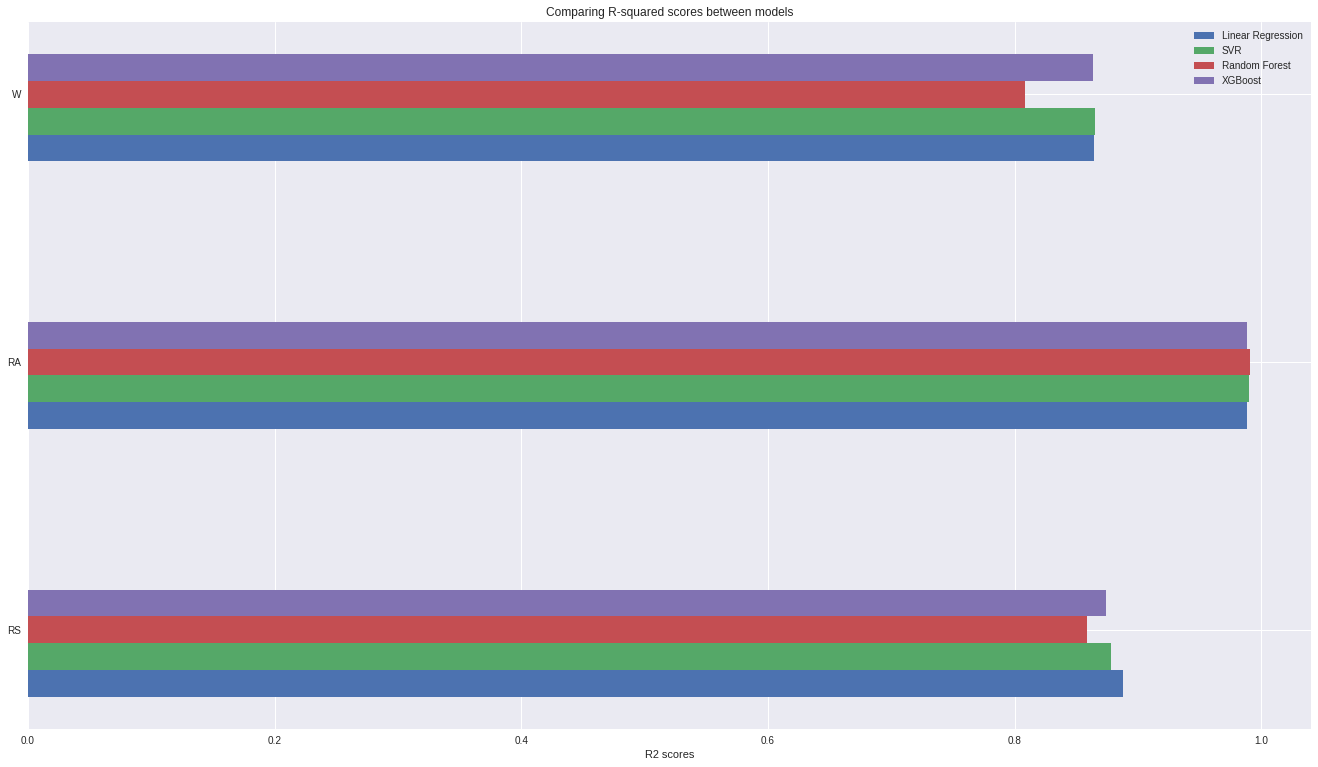

In [652]:
x_labels = ["RS","RA","W"]
# set distance between plots
N = 3
ind = np.arange(N)
width = 0.1
x = (ind)+(4*width)/2

plt.rcParams['figure.figsize'] = (23,13)
plt.barh(ind,LinR2,width,label="Linear Regression")
plt.barh(ind+width,SVR2,width,label="SVR")
plt.barh(ind+(2*width),RFR2,width,label="Random Forest")
plt.barh(ind+(3*width),XGR2,width,label="XGBoost")
plt.yticks(x,x_labels)
plt.xlabel("R2 scores")
plt.legend()
plt.title("Comparing R-squared scores between models")
plt.show()

In [653]:
model_comp = pd.DataFrame(index={"RS","RA","W"})
model_comp["Multivariate Linear Regression (R2)"] = LinR2
model_comp["SVR (R2)"] = SVR2
model_comp["Random Forest (R2)"] = RFR2
model_comp["XGBoost (R2)"] = XGR2
display(model_comp)

,Multivariate Linear Regression (R2),SVR (R2),Random Forest (R2),XGBoost (R2)
RS,0.888041,0.877907,0.858825,0.873874
RA,0.988727,0.990392,0.991130,0.988332
W,0.864487,0.865069,0.808730,0.863720


The three models with the most consistently high R-squared values are Multivariate Linear Regression, Support Vector Regression, & XGBoost. It appears that Multivariate Linear Regression has the most consistently high R-squared values of the three, but Support Vector Regression is also fairly consistent in high R-squared values. Going to use Support Vector Regression because Multivariate Linear Regression has been a common regression model for this type of analysis. We are going to explore the SVR model and see how close we can get to the actual and estimated values for the Oakland A's 2002 season.

## Tuning Hyperparameters for higher R-squared values (SVR)

We can try finding the best combination for our SVR's hyperparameters to see if the R-squared values can be improved. If the R-squared values improve as a result of the change, then we can be reasonably confident that SVR is a more accurate model compared to the Multivariate Linear Regression Model. We will be comparing the results for  randomized search cross validation tuner and grid search cross validation, for finding the best parameters for SVR model. 

### Randomized Search Cross Validation

In [654]:
from sklearn.model_selection import RandomizedSearchCV

# penalty parameter of the error term (C)
c_param = [int(x) for x in np.linspace(start=1,stop=1000,num=100)]
# kernel type to be used for SVR
kernel_param = ["linear","rbf"]
# kernel coefficient (gamma)
gamma_param = [x for x in np.linspace(start=0.001,stop=1,num=100)]

# create random grid
svr_random_grid = {
    "C":c_param,
    "kernel":kernel_param,
    "gamma":gamma_param
}

In [655]:
# search for best hyperparameters using 10-fold cross validation 

#RS
svr_RS_random = RandomizedSearchCV(estimator=svr_RS,param_distributions=svr_random_grid,n_iter=60,cv=10,verbose=2,random_state=42,n_jobs=-1)
svr_RS_random.fit(XRS_sc_train,yRS_sc_train.ravel())

# RA
svr_RA_random = RandomizedSearchCV(estimator=svr_RA,param_distributions=svr_random_grid,n_iter=60,cv=10,verbose=2,random_state=42,n_jobs=-1)
svr_RA_random.fit(XRA_sc_train,yRA_sc_train.ravel())

# W
svr_W_random = RandomizedSearchCV(estimator=svr_W,param_distributions=svr_random_grid,n_iter=60,cv=10,verbose=2,random_state=42,n_jobs=-1)
svr_W_random.fit(XW_sc_train,yW_sc_train.ravel())
;

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] ...... kernel=rbf, gamma=0.9798181818181818, C=788, total=   1.4s
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] ...... kernel=rbf, gamma=0.9798181818181818, C=788, total=   1.5s
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] ...... kernel=rbf, gamma=0.9798181818181818, C=788, total=   1.6s
[CV] kernel=li

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.5s


[CV] ... kernel=linear, gamma=0.9596363636363637, C=263, total=   2.0s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.9596363636363637, C=263, total=   1.8s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.9596363636363637, C=263, total=   1.7s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.9596363636363637, C=263, total=   1.6s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.9596363636363637, C=263, total=   1.7s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.8284545454545454, C=596, total=   2.8s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.8284545454545454, C=596, total=   3.5s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] .

[CV] ................... kernel=rbf, gamma=0.112, C=727, total=   0.3s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] .. kernel=linear, gamma=0.25327272727272726, C=848, total=   4.7s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] ................... kernel=rbf, gamma=0.112, C=727, total=   0.3s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] ................... kernel=rbf, gamma=0.112, C=727, total=   0.3s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] ................... kernel=rbf, gamma=0.112, C=727, total=   0.3s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] .. kernel=linear, gamma=0.13218181818181818, C=223, total=   1.5s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] ...... kernel=rbf, gamma=0.8183636363636364, C=566, total=   0.8s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] .

[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=122, total=   0.1s
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=122, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=122 ....................
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=122, total=   0.1s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=122, total=   0.1s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=122, total=   0.1s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=122, total=   0.1s
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=122, total=   0.2s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] kernel=rbf, gamma=0.556, C=263 ..................................


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.3s


[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.3s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.3s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.4s
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.4s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.4s
[CV] kernel=rbf, gamma=0.25327272727272726, C=253 ....................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.5s
[CV] kernel=rbf, gamma=0.25327272727272726, C=253 ....................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.4s
[CV] ..... kernel=rbf, gamma=0.25327272727272726, C=253, total=   0.2s
[CV] k

[CV] .... kernel=linear, gamma=0.989909090909091, C=313, total=   2.3s
[CV] kernel=linear, gamma=0.334, C=434 ...............................
[CV] .... kernel=linear, gamma=0.989909090909091, C=313, total=   1.9s
[CV] kernel=linear, gamma=0.334, C=434 ...............................
[CV] .... kernel=linear, gamma=0.989909090909091, C=313, total=   1.9s
[CV] kernel=linear, gamma=0.334, C=434 ...............................
[CV] .... kernel=linear, gamma=0.989909090909091, C=313, total=   2.1s
[CV] kernel=linear, gamma=0.334, C=434 ...............................
[CV] ................ kernel=linear, gamma=0.334, C=434, total=   3.0s
[CV] kernel=linear, gamma=0.334, C=434 ...............................
[CV] ................ kernel=linear, gamma=0.334, C=434, total=   2.8s
[CV] kernel=linear, gamma=0.334, C=434 ...............................
[CV] ................ kernel=linear, gamma=0.334, C=434, total=   2.9s
[CV] kernel=linear, gamma=0.7174545454545455, C=949 ..................
[CV] .

[CV] .... kernel=rbf, gamma=0.021181818181818184, C=152, total=   0.1s
[CV] kernel=rbf, gamma=0.021181818181818184, C=152 ...................
[CV] .... kernel=rbf, gamma=0.021181818181818184, C=152, total=   0.0s
[CV] kernel=rbf, gamma=0.021181818181818184, C=152 ...................
[CV] .... kernel=rbf, gamma=0.021181818181818184, C=152, total=   0.0s
[CV] .... kernel=rbf, gamma=0.021181818181818184, C=152, total=   0.1s
[CV] kernel=rbf, gamma=0.021181818181818184, C=152 ...................
[CV] kernel=rbf, gamma=0.021181818181818184, C=152 ...................
[CV] .... kernel=rbf, gamma=0.021181818181818184, C=152, total=   0.1s
[CV] .... kernel=rbf, gamma=0.021181818181818184, C=152, total=   0.1s
[CV] kernel=rbf, gamma=0.021181818181818184, C=152 ...................
[CV] kernel=rbf, gamma=0.021181818181818184, C=152 ...................
[CV] .... kernel=rbf, gamma=0.021181818181818184, C=152, total=   0.1s
[CV] kernel=rbf, gamma=0.021181818181818184, C=152 ...................
[CV] .

[CV] ... kernel=linear, gamma=0.9798181818181818, C=566, total=   4.5s
[CV] kernel=linear, gamma=0.4550909090909091, C=192 ..................
[CV] ... kernel=linear, gamma=0.7880909090909092, C=172, total=   1.1s
[CV] kernel=linear, gamma=0.4550909090909091, C=192 ..................
[CV] ... kernel=linear, gamma=0.7880909090909092, C=172, total=   1.1s
[CV] kernel=linear, gamma=0.4550909090909091, C=192 ..................
[CV] ... kernel=linear, gamma=0.7880909090909092, C=172, total=   1.3s
[CV] kernel=linear, gamma=0.4550909090909091, C=192 ..................
[CV] ... kernel=linear, gamma=0.7880909090909092, C=172, total=   1.0s
[CV] kernel=linear, gamma=0.4550909090909091, C=192 ..................
[CV] ... kernel=linear, gamma=0.7880909090909092, C=172, total=   1.0s
[CV] kernel=linear, gamma=0.4550909090909091, C=192 ..................
[CV] ... kernel=linear, gamma=0.9798181818181818, C=566, total=   3.8s
[CV] kernel=linear, gamma=0.4550909090909091, C=192 ..................
[CV] .

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min


[CV] .. kernel=linear, gamma=0.19272727272727275, C=445, total=   2.9s
[CV] kernel=linear, gamma=0.5156363636363637, C=727 ..................
[CV] ... kernel=linear, gamma=0.5156363636363637, C=727, total=   4.5s
[CV] kernel=linear, gamma=0.5156363636363637, C=727 ..................
[CV] ... kernel=linear, gamma=0.5156363636363637, C=727, total=   4.5s
[CV] kernel=linear, gamma=0.5156363636363637, C=727 ..................
[CV] ... kernel=linear, gamma=0.5156363636363637, C=727, total=   4.2s
[CV] kernel=rbf, gamma=0.13218181818181818, C=535 ....................
[CV] ..... kernel=rbf, gamma=0.13218181818181818, C=535, total=   0.3s
[CV] kernel=rbf, gamma=0.13218181818181818, C=535 ....................
[CV] ... kernel=linear, gamma=0.5156363636363637, C=727, total=   5.1s
[CV] ... kernel=linear, gamma=0.5156363636363637, C=727, total=   4.8s
[CV] kernel=rbf, gamma=0.13218181818181818, C=535 ....................
[CV] kernel=rbf, gamma=0.13218181818181818, C=535 ....................
[CV] .

[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=424, total=   0.3s
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=424, total=   0.3s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=424, total=   0.3s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=515, total=   0.3s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=515, total=   0.3s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=515, total=   0.3s
[CV] kernel=linear, gamma=0.08172727272727273, C=556 .................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=515, total=   0.3s
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=515, total=   0.3s
[CV] k

[CV] .. kernel=linear, gamma=0.03127272727272727, C=616, total=   4.7s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.03127272727272727, C=616, total=   4.7s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.03127272727272727, C=616, total=   4.8s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.13218181818181818, C=414, total=   2.5s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.13218181818181818, C=414, total=   2.6s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.03127272727272727, C=616, total=   3.3s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.13218181818181818, C=414, total=   2.9s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .

[CV] ..... kernel=rbf, gamma=0.28354545454545454, C=979, total=   0.7s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] ..... kernel=rbf, gamma=0.28354545454545454, C=979, total=   0.7s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] ..... kernel=rbf, gamma=0.28354545454545454, C=979, total=   0.9s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] ...... kernel=rbf, gamma=0.10190909090909092, C=51, total=   0.0s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] ...... kernel=rbf, gamma=0.10190909090909092, C=51, total=   0.1s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] ...... kernel=rbf, gamma=0.10190909090909092, C=51, total=   0.1s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] ...... kernel=rbf, gamma=0.10190909090909092, C=51, total=   0.0s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] .

[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   3.3s
[CV] kernel=linear, gamma=0.4651818181818182, C=485 ..................
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   3.1s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   3.3s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   3.1s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   3.7s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   3.5s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   3.7s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  2.2min finished


[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] ...... kernel=rbf, gamma=0.9798181818181818, C=788, total=   0.2s
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] ...... kernel=rbf, gamma=0.9798181818181818, C=788, total=   0.2s
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] ...... kernel=rbf, gamma=0.9798181818181818, C=788, total=   0.2s
[CV] ...... kernel=rbf, gamma=0.9798181818181818, C=788, total=   0.2s
[CV] k

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s


[CV] ... kernel=linear, gamma=0.9596363636363637, C=263, total=   0.3s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.8284545454545454, C=596, total=   1.0s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.8284545454545454, C=596, total=   1.0s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.8284545454545454, C=596, total=   1.2s
[CV] ... kernel=linear, gamma=0.8284545454545454, C=596, total=   1.2s
[CV] kernel=linear, gamma=0.4248181818181818, C=566 ..................
[CV] kernel=linear, gamma=0.4248181818181818, C=566 ..................
[CV] ... kernel=linear, gamma=0.8284545454545454, C=596, total=   1.4s
[CV] kernel=linear, gamma=0.4248181818181818, C=566 ..................
[CV] ... kernel=linear, gamma=0.8284545454545454, C=596, total=   0.7s
[CV] kernel=linear, gamma=0.4248181818181818, C=566 ..................
[CV] .

[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] ...... kernel=rbf, gamma=0.8183636363636364, C=566, total=   0.1s
[CV] ...... kernel=rbf, gamma=0.8183636363636364, C=566, total=   0.2s
[CV] ...... kernel=rbf, gamma=0.8183636363636364, C=566, total=   0.2s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] ...... kernel=rbf, gamma=0.8183636363636364, C=566, total=   0.2s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] ...... kernel=rbf, gamma=0.8183636363636364, C=566, total=   0.2s
[CV] kernel=rbf, gamma=0.112, C=808 ..................................
[CV] ...... kernel=rbf, gamma=0.8183636363636364, C=566, total=   0.3s
[CV] kernel=rbf, gamma=0.112, C=808 ..................................
[CV] .

[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=122, total=   0.1s
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=122, total=   0.0s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.1s
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.1s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.1s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ... kernel=linear, gamma=0.6165454545454546, C=414, total=   0.6s
[CV] kernel=rbf, gamma=0.25327272727272726, C=253 ....................
[CV] ... kernel=linear, gamma=0.6165454545454546, C=414, total=   0.7s
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.1s
[CV] k

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.2s


[CV] ... kernel=linear, gamma=0.6165454545454546, C=414, total=   0.7s
[CV] ..... kernel=rbf, gamma=0.25327272727272726, C=253, total=   0.0s
[CV] kernel=linear, gamma=0.10190909090909092, C=323 .................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.1s
[CV] kernel=linear, gamma=0.10190909090909092, C=323 .................
[CV] kernel=rbf, gamma=0.25327272727272726, C=253 ....................
[CV] ..... kernel=rbf, gamma=0.25327272727272726, C=253, total=   0.1s
[CV] ..... kernel=rbf, gamma=0.25327272727272726, C=253, total=   0.1s
[CV] kernel=rbf, gamma=0.25327272727272726, C=253 ....................
[CV] ..... kernel=rbf, gamma=0.25327272727272726, C=253, total=   0.1s
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.1s
[CV] kernel=linear, gamma=0.10190909090909092, C=323 .................
[CV] kernel=linear, gamma=0.10190909090909092, C=323 .................
[CV] ..... kernel=rbf, gamma=0.25327272727272726, C=253, total=   0.1s
[CV] k

[CV] ................ kernel=linear, gamma=0.334, C=434, total=   1.1s
[CV] kernel=linear, gamma=0.7174545454545455, C=949 ..................
[CV] ... kernel=linear, gamma=0.7174545454545455, C=949, total=   2.2s
[CV] kernel=linear, gamma=0.7174545454545455, C=949 ..................
[CV] ... kernel=linear, gamma=0.7174545454545455, C=949, total=   2.0s
[CV] kernel=linear, gamma=0.7174545454545455, C=949 ..................
[CV] ... kernel=linear, gamma=0.7174545454545455, C=949, total=   1.2s
[CV] kernel=rbf, gamma=0.15236363636363637, C=929 ....................
[CV] ... kernel=linear, gamma=0.7174545454545455, C=949, total=   1.8s
[CV] kernel=rbf, gamma=0.15236363636363637, C=929 ....................
[CV] ..... kernel=rbf, gamma=0.15236363636363637, C=929, total=   0.2s
[CV] kernel=rbf, gamma=0.15236363636363637, C=929 ....................
[CV] ..... kernel=rbf, gamma=0.15236363636363637, C=929, total=   0.1s
[CV] ... kernel=linear, gamma=0.7174545454545455, C=949, total=   1.8s
[CV] k

[CV] ....... kernel=rbf, gamma=0.4954545454545455, C=91, total=   0.0s
[CV] kernel=rbf, gamma=0.4954545454545455, C=91 ......................
[CV] ... kernel=linear, gamma=0.8486363636363636, C=878, total=   9.8s
[CV] kernel=linear, gamma=0.8486363636363636, C=878 ..................
[CV] ....... kernel=rbf, gamma=0.4954545454545455, C=91, total=   0.0s
[CV] kernel=rbf, gamma=0.4954545454545455, C=91 ......................
[CV] ....... kernel=rbf, gamma=0.4954545454545455, C=91, total=   0.0s
[CV] kernel=rbf, gamma=0.4954545454545455, C=91 ......................
[CV] ....... kernel=rbf, gamma=0.4954545454545455, C=91, total=   0.0s
[CV] kernel=rbf, gamma=0.4954545454545455, C=91 ......................
[CV] ....... kernel=rbf, gamma=0.4954545454545455, C=91, total=   0.0s
[CV] kernel=rbf, gamma=0.4954545454545455, C=91 ......................
[CV] ....... kernel=rbf, gamma=0.4954545454545455, C=91, total=   0.0s
[CV] ....... kernel=rbf, gamma=0.4954545454545455, C=91, total=   0.0s
[CV] k

[CV] ... kernel=linear, gamma=0.4550909090909091, C=192, total=   0.3s
[CV] kernel=linear, gamma=0.19272727272727275, C=445 .................
[CV] ... kernel=linear, gamma=0.4550909090909091, C=192, total=   0.4s
[CV] kernel=linear, gamma=0.19272727272727275, C=445 .................
[CV] ... kernel=linear, gamma=0.4550909090909091, C=192, total=   0.5s
[CV] kernel=linear, gamma=0.19272727272727275, C=445 .................
[CV] .. kernel=linear, gamma=0.19272727272727275, C=445, total=   0.7s
[CV] kernel=linear, gamma=0.19272727272727275, C=445 .................
[CV] .. kernel=linear, gamma=0.19272727272727275, C=445, total=   1.0s
[CV] kernel=linear, gamma=0.19272727272727275, C=445 .................
[CV] .. kernel=linear, gamma=0.19272727272727275, C=445, total=   0.8s
[CV] kernel=linear, gamma=0.19272727272727275, C=445 .................
[CV] .. kernel=linear, gamma=0.19272727272727275, C=445, total=   1.0s
[CV] kernel=linear, gamma=0.19272727272727275, C=445 .................
[CV] .

[CV] ..... kernel=rbf, gamma=0.26336363636363636, C=515, total=   0.2s
[CV] ..... kernel=rbf, gamma=0.26336363636363636, C=515, total=   0.1s
[CV] kernel=rbf, gamma=0.26336363636363636, C=515 ....................
[CV] kernel=rbf, gamma=0.16245454545454546, C=424 ....................
[CV] ... kernel=linear, gamma=0.5660909090909091, C=899, total=   1.5s
[CV] kernel=rbf, gamma=0.16245454545454546, C=424 ....................
[CV] ..... kernel=rbf, gamma=0.26336363636363636, C=515, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=424 ....................
[CV] ..... kernel=rbf, gamma=0.26336363636363636, C=515, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=424 ....................
[CV] ..... kernel=rbf, gamma=0.26336363636363636, C=515, total=   0.1s
[CV] ..... kernel=rbf, gamma=0.26336363636363636, C=515, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=424 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=424, total=   0.1s
[CV] k

[Parallel(n_jobs=-1)]: Done 391 tasks      | elapsed:   34.0s


[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=424, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=424, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=424, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=424, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=424, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=515, total=   0.1s
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=515, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] k

[CV] kernel=linear, gamma=0.03127272727272727, C=616 .................
[CV] .. kernel=linear, gamma=0.03127272727272727, C=616, total=   1.4s
[CV] kernel=linear, gamma=0.03127272727272727, C=616 .................
[CV] .. kernel=linear, gamma=0.03127272727272727, C=616, total=   1.8s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] ... kernel=linear, gamma=0.9697272727272728, C=434, total=   6.7s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.03127272727272727, C=616, total=   1.9s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.03127272727272727, C=616, total=   0.9s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.03127272727272727, C=616, total=   0.8s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.03127272727272727, C=616, total=   0.8s
[CV] k

[CV] kernel=rbf, gamma=0.28354545454545454, C=979 ....................
[CV] ..... kernel=rbf, gamma=0.28354545454545454, C=979, total=   0.2s
[CV] ..... kernel=rbf, gamma=0.28354545454545454, C=979, total=   0.2s
[CV] kernel=rbf, gamma=0.28354545454545454, C=979 ....................
[CV] kernel=rbf, gamma=0.28354545454545454, C=979 ....................
[CV] ..... kernel=rbf, gamma=0.28354545454545454, C=979, total=   0.2s
[CV] kernel=rbf, gamma=0.28354545454545454, C=979 ....................
[CV] ..... kernel=rbf, gamma=0.28354545454545454, C=979, total=   0.2s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] ..... kernel=rbf, gamma=0.28354545454545454, C=979, total=   0.2s
[CV] ..... kernel=rbf, gamma=0.28354545454545454, C=979, total=   0.2s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] ...... kernel=rbf, gamma=0.10190909090909092, C=51, total=   0.0s
[CV] k

[CV] kernel=linear, gamma=0.4651818181818182, C=485 ..................
[CV] ...... kernel=rbf, gamma=0.9495454545454546, C=394, total=   0.2s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] ...... kernel=rbf, gamma=0.9495454545454546, C=394, total=   0.2s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   0.8s
[CV] kernel=linear, gamma=0.4651818181818182, C=485 ..................
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   0.9s
[CV] kernel=linear, gamma=0.4651818181818182, C=485 ..................
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   1.2s
[CV] kernel=linear, gamma=0.4651818181818182, C=485 ..................
[CV] ... kernel=linear, gamma=0.9596363636363637, C=646, total=   0.9s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   1.3s
[CV] k

[Parallel(n_jobs=-1)]: Done 585 out of 600 | elapsed:   45.5s remaining:    1.2s


[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   1.1s
[CV] ... kernel=linear, gamma=0.9596363636363637, C=646, total=   2.2s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] .. kernel=linear, gamma=0.03127272727272727, C=616, total=   7.5s
[CV] ... kernel=linear, gamma=0.9596363636363637, C=646, total=   0.7s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] ... kernel=linear, gamma=0.9596363636363637, C=646, total=   1.4s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] ... kernel=linear, gamma=0.9596363636363637, C=646, total=   1.8s
[CV] ... kernel=linear, gamma=0.9596363636363637, C=646, total=   0.8s
[CV] ... kernel=linear, gamma=0.9596363636363637, C=646, total=   1.0s
[CV] ... kernel=linear, gamma=0.9596363636363637, C=646, total=   1.7s
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   5.9s
[CV] kernel=linear, gamma=0.4651818181818182, C=485 ..................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   51.9s finished


Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] ...... kernel=rbf, gamma=0.9798181818181818, C=788, total=   0.2s
[CV] ...... kernel=rbf, gamma=0.9798181818181818, C=788, total=   0.2s
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] kernel=rbf, gamma=0.9798181818181818, C=788 .....................
[CV] ...... kernel=rbf, gamma=0.9798181818181818, C=788, total=   0.3s
[CV] ...... ke

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s


[CV] ... kernel=linear, gamma=0.9596363636363637, C=263, total=   0.8s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.9596363636363637, C=263, total=   0.8s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.9596363636363637, C=263, total=   0.9s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.8284545454545454, C=596, total=   1.1s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.8284545454545454, C=596, total=   1.5s
[CV] kernel=linear, gamma=0.8284545454545454, C=596 ..................
[CV] ... kernel=linear, gamma=0.8284545454545454, C=596, total=   1.6s
[CV] kernel=linear, gamma=0.4248181818181818, C=566 ..................
[CV] ... kernel=linear, gamma=0.8284545454545454, C=596, total=   1.8s
[CV] kernel=linear, gamma=0.4248181818181818, C=566 ..................
[CV] .

[CV] ................... kernel=rbf, gamma=0.112, C=727, total=   0.1s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] ................... kernel=rbf, gamma=0.112, C=727, total=   0.1s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] .. kernel=linear, gamma=0.13218181818181818, C=223, total=   0.7s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] ...... kernel=rbf, gamma=0.8183636363636364, C=566, total=   0.1s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] .. kernel=linear, gamma=0.13218181818181818, C=223, total=   0.6s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] ...... kernel=rbf, gamma=0.8183636363636364, C=566, total=   0.2s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] ...... kernel=rbf, gamma=0.8183636363636364, C=566, total=   0.2s
[CV] kernel=rbf, gamma=0.8183636363636364, C=566 .....................
[CV] .

[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=122, total=   0.1s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=122, total=   0.0s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=122, total=   0.0s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.1s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.1s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.1s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.1s
[CV] kernel=rbf, gamma=0.556, C=263 ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   11.6s


[CV] kernel=rbf, gamma=0.25327272727272726, C=253 ....................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.1s
[CV] kernel=rbf, gamma=0.25327272727272726, C=253 ....................
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.1s
[CV] kernel=rbf, gamma=0.25327272727272726, C=253 ....................
[CV] ... kernel=linear, gamma=0.6165454545454546, C=414, total=   1.0s
[CV] kernel=rbf, gamma=0.25327272727272726, C=253 ....................
[CV] ..... kernel=rbf, gamma=0.25327272727272726, C=253, total=   0.1s
[CV] ................... kernel=rbf, gamma=0.556, C=263, total=   0.1s
[CV] kernel=rbf, gamma=0.25327272727272726, C=253 ....................
[CV] kernel=rbf, gamma=0.25327272727272726, C=253 ....................
[CV] ..... kernel=rbf, gamma=0.25327272727272726, C=253, total=   0.1s
[CV] kernel=rbf, gamma=0.25327272727272726, C=253 ....................
[CV] ... kernel=linear, gamma=0.6165454545454546, C=414, total=   1.0s
[CV] .

[CV] kernel=linear, gamma=0.334, C=434 ...............................
[CV] ................ kernel=linear, gamma=0.334, C=434, total=   1.0s
[CV] kernel=linear, gamma=0.334, C=434 ...............................
[CV] ................ kernel=linear, gamma=0.334, C=434, total=   1.1s
[CV] kernel=linear, gamma=0.7174545454545455, C=949 ..................
[CV] ................ kernel=linear, gamma=0.334, C=434, total=   1.6s
[CV] kernel=linear, gamma=0.7174545454545455, C=949 ..................
[CV] ................ kernel=linear, gamma=0.334, C=434, total=   1.1s
[CV] kernel=linear, gamma=0.7174545454545455, C=949 ..................
[CV] ................ kernel=linear, gamma=0.334, C=434, total=   1.1s
[CV] kernel=linear, gamma=0.7174545454545455, C=949 ..................
[CV] ................ kernel=linear, gamma=0.334, C=434, total=   1.0s
[CV] kernel=linear, gamma=0.7174545454545455, C=949 ..................
[CV] ................ kernel=linear, gamma=0.334, C=434, total=   1.0s
[CV] k

[CV] kernel=rbf, gamma=0.021181818181818184, C=152 ...................
[CV] .... kernel=rbf, gamma=0.021181818181818184, C=152, total=   0.0s
[CV] kernel=rbf, gamma=0.021181818181818184, C=152 ...................
[CV] .... kernel=rbf, gamma=0.021181818181818184, C=152, total=   0.0s
[CV] kernel=rbf, gamma=0.021181818181818184, C=152 ...................
[CV] .... kernel=rbf, gamma=0.021181818181818184, C=152, total=   0.0s
[CV] .... kernel=rbf, gamma=0.021181818181818184, C=152, total=   0.0s
[CV] kernel=rbf, gamma=0.021181818181818184, C=152 ...................
[CV] kernel=rbf, gamma=0.4954545454545455, C=91 ......................
[CV] .... kernel=rbf, gamma=0.021181818181818184, C=152, total=   0.0s
[CV] kernel=rbf, gamma=0.4954545454545455, C=91 ......................
[CV] ....... kernel=rbf, gamma=0.4954545454545455, C=91, total=   0.1s
[CV] kernel=rbf, gamma=0.4954545454545455, C=91 ......................
[CV] ... kernel=linear, gamma=0.5963636363636364, C=959, total=   2.0s
[CV] k

[CV] kernel=linear, gamma=0.4550909090909091, C=192 ..................
[CV] ... kernel=linear, gamma=0.7880909090909092, C=172, total=   0.5s
[CV] kernel=linear, gamma=0.4550909090909091, C=192 ..................
[CV] ... kernel=linear, gamma=0.4550909090909091, C=192, total=   0.4s
[CV] kernel=linear, gamma=0.4550909090909091, C=192 ..................
[CV] ... kernel=linear, gamma=0.7880909090909092, C=172, total=   0.6s
[CV] kernel=linear, gamma=0.4550909090909091, C=192 ..................
[CV] ... kernel=linear, gamma=0.4550909090909091, C=192, total=   0.6s
[CV] kernel=linear, gamma=0.4550909090909091, C=192 ..................
[CV] ... kernel=linear, gamma=0.4550909090909091, C=192, total=   0.6s
[CV] kernel=linear, gamma=0.4550909090909091, C=192 ..................
[CV] ... kernel=linear, gamma=0.4550909090909091, C=192, total=   0.5s
[CV] kernel=linear, gamma=0.19272727272727275, C=445 .................
[CV] ... kernel=linear, gamma=0.4550909090909091, C=192, total=   0.5s
[CV] k

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   36.6s


[CV] ... kernel=linear, gamma=0.5156363636363637, C=727, total=   1.7s
[CV] kernel=linear, gamma=0.5156363636363637, C=727 ..................
[CV] ... kernel=linear, gamma=0.5156363636363637, C=727, total=   1.8s
[CV] kernel=linear, gamma=0.5156363636363637, C=727 ..................
[CV] ... kernel=linear, gamma=0.5156363636363637, C=727, total=   1.7s
[CV] kernel=rbf, gamma=0.13218181818181818, C=535 ....................
[CV] ..... kernel=rbf, gamma=0.13218181818181818, C=535, total=   0.1s
[CV] kernel=rbf, gamma=0.13218181818181818, C=535 ....................
[CV] ..... kernel=rbf, gamma=0.13218181818181818, C=535, total=   0.1s
[CV] kernel=rbf, gamma=0.13218181818181818, C=535 ....................
[CV] ... kernel=linear, gamma=0.5156363636363637, C=727, total=   1.8s
[CV] kernel=rbf, gamma=0.13218181818181818, C=535 ....................
[CV] ..... kernel=rbf, gamma=0.13218181818181818, C=535, total=   0.1s
[CV] kernel=rbf, gamma=0.13218181818181818, C=535 ....................
[CV] .

[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=424, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=515, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=424, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=515, total=   0.1s
[CV] kernel=rbf, gamma=0.16245454545454546, C=515 ....................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=515, total=   0.1s
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=515, total=   0.1s
[CV] kernel=linear, gamma=0.08172727272727273, C=556 .................
[CV] kernel=linear, gamma=0.08172727272727273, C=556 .................
[CV] ..... kernel=rbf, gamma=0.16245454545454546, C=515, total=   0.1s
[CV] kernel=linear, gamma=0.08172727272727273, C=556 .................
[CV] .

[CV] .. kernel=linear, gamma=0.03127272727272727, C=616, total=   1.7s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.13218181818181818, C=414, total=   1.1s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.03127272727272727, C=616, total=   1.3s
[CV] .. kernel=linear, gamma=0.13218181818181818, C=414, total=   0.9s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.13218181818181818, C=414, total=   1.0s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.13218181818181818, C=414, total=   1.0s
[CV] kernel=linear, gamma=0.13218181818181818, C=414 .................
[CV] .. kernel=linear, gamma=0.13218181818181818, C=414, total=   1.2s
[CV] kernel=rbf, gamma=0.7073636363636364, C=727 .....................
[CV] .

[CV] ..... kernel=rbf, gamma=0.28354545454545454, C=979, total=   0.2s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] ...... kernel=rbf, gamma=0.10190909090909092, C=51, total=   0.0s
[CV] ...... kernel=rbf, gamma=0.10190909090909092, C=51, total=   0.0s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] ..... kernel=rbf, gamma=0.28354545454545454, C=979, total=   0.2s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] ..... kernel=rbf, gamma=0.28354545454545454, C=979, total=   0.2s
[CV] ..... kernel=rbf, gamma=0.28354545454545454, C=979, total=   0.2s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] ...... kernel=rbf, gamma=0.10190909090909092, C=51, total=   0.0s
[CV] kernel=rbf, gamma=0.10190909090909092, C=51 .....................
[CV] .

[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   1.4s
[CV] kernel=linear, gamma=0.4651818181818182, C=485 ..................
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   1.5s
[CV] kernel=linear, gamma=0.4651818181818182, C=485 ..................
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   1.6s
[CV] kernel=linear, gamma=0.4651818181818182, C=485 ..................
[CV] ... kernel=linear, gamma=0.9596363636363637, C=646, total=   1.4s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] ... kernel=linear, gamma=0.9596363636363637, C=646, total=   1.7s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] ... kernel=linear, gamma=0.9596363636363637, C=646, total=   2.1s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] ... kernel=linear, gamma=0.4651818181818182, C=485, total=   1.3s
[CV] kernel=linear, gamma=0.9596363636363637, C=646 ..................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   55.3s finished


''

In [656]:
print("RS best parameters\n",svr_RS_random.best_params_)
print("\n----------------------------------------\n")
print("\nRA best parameters\n",svr_RA_random.best_params_)
print("\n----------------------------------------\n")
print("\nW best parameters\n",svr_W_random.best_params_)

RS best parameters
 {'kernel': 'rbf', 'gamma': 0.10190909090909092, 'C': 51}

----------------------------------------


RA best parameters
 {'kernel': 'linear', 'gamma': 0.30372727272727273, 'C': 41}

----------------------------------------


W best parameters
 {'kernel': 'rbf', 'gamma': 0.021181818181818184, 'C': 152}


### Grid Search Cross Validation

Need to have slightly different grid values for grid search for the sake of time efficieny. We will use less variety of values and less folds than randomized search cross validation. This may cause some bias when comparing grid search to randomized search in terms of which model gives the best parameters for SVR tuning. 

In [657]:
from sklearn.model_selection import GridSearchCV

# penalty parameter of the error term (C)
c_param = [int(x) for x in np.linspace(start=1,stop=1000,num=10)]
# kernel type to be used for SVR
kernel_param = ["linear","rbf"]
# kernel coefficient (gamma)
gamma_param = [x for x in np.linspace(start=0.001,stop=1,num=10)]

# create random grid
svr_random_grid = {
    "C":c_param,
    "kernel":kernel_param,
    "gamma":gamma_param
}

# RS
svr_RS_grid = GridSearchCV(estimator=svr_RS,param_grid=svr_random_grid,cv=3,verbose=2,n_jobs=-1)
svr_RS_grid.fit(XRS_sc_train,yRS_sc_train.ravel())

# RA
svr_RA_grid = GridSearchCV(estimator=svr_RA,param_grid=svr_random_grid,cv=3,verbose=2,n_jobs=-1)
svr_RA_grid.fit(XRA_sc_train,yRA_sc_train.ravel())

# W
svr_W_grid = GridSearchCV(estimator=svr_W,param_grid=svr_random_grid,cv=3,verbose=2,n_jobs=-1)
svr_W_grid.fit(XRA_sc_train,yRA_sc_train.ravel())

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] C=1, gamma=0.112, kernel=linear .................................
[CV] C=1, gamma=0.112, kernel=linear .................................
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] .................. C=1, gamma=0.112, kernel=linear, total=   0.0s
[CV] .................. C=1, gamma=0.112, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.112, kernel=linear .................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamm

[CV] .................. C=1, gamma=0.667, kernel=linear, total=   0.0s
[CV] C=112, gamma=0.334, kernel=linear ...............................
[CV] ..................... C=1, gamma=0.889, kernel=rbf, total=   0.0s
[CV] C=1, gamma=1.0, kernel=linear ...................................
[CV] .................. C=1, gamma=0.556, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.667, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.334, kernel=rbf, total=   0.0s
[CV] C=112, gamma=0.445, kernel=rbf ..................................
[CV] C=1, gamma=0.556, kernel=linear .................................
[CV] .................... C=1, gamma=1.0, kernel=linear, total=   0.0s
[CV] ..................... C=1, gamma=0.667, kernel=rbf, total=   0.0s
[CV] C=112, gamma=0.667, kernel=linear ...............................
[CV] .................. C=1, gamma=0.556, kernel=linear, total=   0.0s
[CV] C=1, gamma=1.0, kernel=linear ...................................
[CV] C

[CV] ..................... C=112, gamma=1.0, kernel=rbf, total=   0.2s
[CV] C=112, gamma=0.445, kernel=rbf ..................................
[CV] C=112, gamma=1.0, kernel=rbf ....................................
[CV] ................ C=223, gamma=0.112, kernel=linear, total=   0.9s
[CV] C=223, gamma=0.112, kernel=rbf ..................................
[CV] ................... C=112, gamma=0.445, kernel=rbf, total=   0.1s
[CV] ................... C=223, gamma=0.223, kernel=rbf, total=   0.1s
[CV] C=223, gamma=0.223, kernel=rbf ..................................
[CV] C=223, gamma=0.445, kernel=linear ...............................
[CV] ..................... C=112, gamma=1.0, kernel=rbf, total=   0.2s
[CV] C=223, gamma=0.556, kernel=linear ...............................
[CV] ................... C=223, gamma=0.112, kernel=rbf, total=   0.1s
[CV] C=223, gamma=0.112, kernel=rbf ..................................
[CV] ................ C=112, gamma=0.889, kernel=linear, total=   0.5s
[CV] C

[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.9s


[CV] ................... C=223, gamma=0.112, kernel=rbf, total=   0.1s
[CV] C=223, gamma=0.112, kernel=rbf ..................................
[CV] ................... C=112, gamma=0.889, kernel=rbf, total=   0.1s
[CV] C=223, gamma=0.667, kernel=rbf ..................................
[CV] ................ C=112, gamma=0.334, kernel=linear, total=   0.5s
[CV] C=223, gamma=0.889, kernel=linear ...............................
[CV] ................... C=223, gamma=0.112, kernel=rbf, total=   0.1s
[CV] C=223, gamma=0.223, kernel=linear ...............................
[CV] ................... C=223, gamma=0.667, kernel=rbf, total=   0.2s
[CV] C=223, gamma=0.667, kernel=rbf ..................................
[CV] ................ C=112, gamma=0.778, kernel=linear, total=   0.6s
[CV] C=223, gamma=1.0, kernel=linear .................................
[CV] ................... C=223, gamma=0.667, kernel=rbf, total=   0.2s
[CV] C=223, gamma=0.778, kernel=linear ...............................
[CV] .

[CV] ................... C=334, gamma=0.445, kernel=rbf, total=   0.3s
[CV] C=334, gamma=0.556, kernel=linear ...............................
[CV] ................ C=334, gamma=0.223, kernel=linear, total=   1.5s
[CV] ................... C=223, gamma=0.667, kernel=rbf, total=   0.4s
[CV] C=334, gamma=0.667, kernel=linear ...............................
[CV] C=334, gamma=0.223, kernel=linear ...............................
[CV] ................ C=334, gamma=0.112, kernel=linear, total=   1.5s
[CV] C=334, gamma=0.112, kernel=linear ...............................
[CV] .................. C=223, gamma=1.0, kernel=linear, total=   1.0s
[CV] C=223, gamma=1.0, kernel=linear .................................
[CV] ................ C=334, gamma=0.334, kernel=linear, total=   1.1s
[CV] C=334, gamma=0.334, kernel=rbf ..................................
[CV] ................... C=334, gamma=0.334, kernel=rbf, total=   0.2s
[CV] C=334, gamma=0.334, kernel=rbf ..................................
[CV] .

[CV] ..................... C=334, gamma=1.0, kernel=rbf, total=   0.7s
[CV] C=445, gamma=0.223, kernel=rbf ..................................
[CV] .................. C=334, gamma=1.0, kernel=linear, total=   1.4s
[CV] C=445, gamma=0.334, kernel=linear ...............................
[CV] ................... C=445, gamma=0.223, kernel=rbf, total=   0.3s
[CV] C=445, gamma=0.223, kernel=rbf ..................................
[CV] ................ C=334, gamma=0.334, kernel=linear, total=   1.4s
[CV] C=445, gamma=0.445, kernel=linear ...............................
[CV] ................... C=445, gamma=0.223, kernel=rbf, total=   0.3s
[CV] C=445, gamma=0.334, kernel=linear ...............................
[CV] ................ C=334, gamma=0.778, kernel=linear, total=   1.6s
[CV] C=334, gamma=0.778, kernel=linear ...............................
[CV] ................ C=445, gamma=0.001, kernel=linear, total=   1.9s
[CV] C=445, gamma=0.001, kernel=linear ...............................
[CV] .

[CV] .................. C=445, gamma=1.0, kernel=linear, total=   1.7s
[CV] C=556, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=556, gamma=0.001, kernel=rbf, total=   0.0s
[CV] ................... C=556, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=556, gamma=0.001, kernel=rbf ..................................
[CV] C=556, gamma=0.112, kernel=linear ...............................
[CV] ................... C=556, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=556, gamma=0.112, kernel=linear ...............................
[CV] .................. C=445, gamma=1.0, kernel=linear, total=   1.7s
[CV] C=556, gamma=0.112, kernel=linear ...............................
[CV] .................. C=445, gamma=1.0, kernel=linear, total=   2.2s
[CV] C=556, gamma=0.112, kernel=rbf ..................................
[CV] ................... C=556, gamma=0.112, kernel=rbf, total=   0.2s
[CV] C=556, gamma=0.112, kernel=rbf ..................................
[CV] .

[CV] ..................... C=556, gamma=1.0, kernel=rbf, total=   0.8s
[CV] C=667, gamma=0.001, kernel=linear ...............................
[CV] ................ C=556, gamma=0.889, kernel=linear, total=   2.7s
[CV] C=667, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=667, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=667, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=667, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=667, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=667, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=667, gamma=0.112, kernel=linear ...............................
[CV] ..................... C=556, gamma=1.0, kernel=rbf, total=   0.9s
[CV] C=667, gamma=0.112, kernel=linear ...............................
[CV] .................. C=556, gamma=1.0, kernel=linear, total=   2.3s
[CV] C=667, gamma=0.112, kernel=linear ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:   35.1s


[CV] ................ C=667, gamma=0.112, kernel=linear, total=   2.7s
[CV] C=667, gamma=0.334, kernel=rbf ..................................
[CV] ................... C=667, gamma=0.334, kernel=rbf, total=   0.3s
[CV] C=667, gamma=0.334, kernel=rbf ..................................
[CV] ................... C=667, gamma=0.334, kernel=rbf, total=   0.4s
[CV] C=667, gamma=0.445, kernel=linear ...............................
[CV] ................... C=667, gamma=0.334, kernel=rbf, total=   0.5s
[CV] C=667, gamma=0.445, kernel=linear ...............................
[CV] ................ C=667, gamma=0.223, kernel=linear, total=   3.2s
[CV] C=667, gamma=0.445, kernel=linear ...............................
[CV] ................ C=667, gamma=0.223, kernel=linear, total=   2.4s
[CV] C=667, gamma=0.445, kernel=rbf ..................................
[CV] ................ C=667, gamma=0.223, kernel=linear, total=   3.5s
[CV] C=667, gamma=0.445, kernel=rbf ..................................
[CV] .

[CV] ................... C=778, gamma=0.223, kernel=rbf, total=   0.4s
[CV] C=778, gamma=0.334, kernel=linear ...............................
[CV] ................ C=778, gamma=0.112, kernel=linear, total=   3.7s
[CV] C=778, gamma=0.334, kernel=rbf ..................................
[CV] ................ C=778, gamma=0.112, kernel=linear, total=   3.2s
[CV] C=778, gamma=0.334, kernel=rbf ..................................
[CV] ................... C=778, gamma=0.334, kernel=rbf, total=   0.4s
[CV] C=778, gamma=0.334, kernel=rbf ..................................
[CV] ................... C=778, gamma=0.334, kernel=rbf, total=   0.4s
[CV] C=778, gamma=0.445, kernel=linear ...............................
[CV] ................... C=778, gamma=0.334, kernel=rbf, total=   0.6s
[CV] C=778, gamma=0.445, kernel=linear ...............................
[CV] ................ C=778, gamma=0.223, kernel=linear, total=   3.1s
[CV] C=778, gamma=0.445, kernel=linear ...............................
[CV] .

[CV] ................ C=889, gamma=0.112, kernel=linear, total=   3.7s
[CV] C=889, gamma=0.334, kernel=linear ...............................
[CV] ................... C=889, gamma=0.223, kernel=rbf, total=   0.5s
[CV] C=889, gamma=0.334, kernel=linear ...............................
[CV] ................... C=889, gamma=0.223, kernel=rbf, total=   0.4s
[CV] C=889, gamma=0.334, kernel=linear ...............................
[CV] ................ C=889, gamma=0.112, kernel=linear, total=   3.2s
[CV] C=889, gamma=0.334, kernel=rbf ..................................
[CV] ................ C=889, gamma=0.112, kernel=linear, total=   3.8s
[CV] C=889, gamma=0.334, kernel=rbf ..................................
[CV] ................... C=889, gamma=0.334, kernel=rbf, total=   0.4s
[CV] C=889, gamma=0.334, kernel=rbf ..................................
[CV] ................... C=889, gamma=0.334, kernel=rbf, total=   0.5s
[CV] C=889, gamma=0.445, kernel=linear ...............................
[CV] .

[CV] C=1000, gamma=0.223, kernel=rbf .................................
[CV] C=1000, gamma=0.223, kernel=rbf .................................
[CV] .................. C=1000, gamma=0.223, kernel=rbf, total=   0.5s
[CV] ............... C=1000, gamma=0.112, kernel=linear, total=   3.4s
[CV] C=1000, gamma=0.223, kernel=rbf .................................
[CV] C=1000, gamma=0.334, kernel=linear ..............................
[CV] .................. C=1000, gamma=0.223, kernel=rbf, total=   0.5s
[CV] C=1000, gamma=0.334, kernel=linear ..............................
[CV] ............... C=1000, gamma=0.112, kernel=linear, total=   4.5s
[CV] C=1000, gamma=0.334, kernel=linear ..............................
[CV] .................. C=1000, gamma=0.223, kernel=rbf, total=   0.5s
[CV] C=1000, gamma=0.334, kernel=rbf .................................
[CV] ............... C=1000, gamma=0.112, kernel=linear, total=   4.4s
[CV] C=1000, gamma=0.334, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=-1)]: Done 575 tasks      | elapsed:  1.4min


[CV] .................. C=1000, gamma=0.667, kernel=rbf, total=   1.2s
[CV] C=1000, gamma=0.778, kernel=linear ..............................
[CV] ............... C=1000, gamma=0.556, kernel=linear, total=   4.5s
[CV] C=1000, gamma=0.778, kernel=linear ..............................
[CV] ............... C=1000, gamma=0.556, kernel=linear, total=   4.1s
[CV] C=1000, gamma=0.778, kernel=rbf .................................
[CV] .................. C=1000, gamma=0.667, kernel=rbf, total=   1.3s
[CV] C=1000, gamma=0.778, kernel=rbf .................................
[CV] .................. C=1000, gamma=0.778, kernel=rbf, total=   0.8s
[CV] C=1000, gamma=0.778, kernel=rbf .................................
[CV] .................. C=1000, gamma=0.778, kernel=rbf, total=   1.1s
[CV] C=1000, gamma=0.889, kernel=linear ..............................
[CV] ............... C=1000, gamma=0.667, kernel=linear, total=   3.4s
[CV] C=1000, gamma=0.889, kernel=linear ..............................
[CV] .

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.6min finished


[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] C=1, gamma=0.112, kernel=linear .................................
[CV] C=1, gamma=0.112, kernel=linear .................................
[CV] .................. C=1, gamma=0.001, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.112, kernel=linear .................................
[CV] .................. C=1, gamma=0.112, kernel=linear, total=   0.0s
[CV] .................. C=1, gamma=0.112, kernel=linear, total=   0.0s
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.112, kernel=rbf ....................................
[CV] C=1, gamma=0.112, kernel=rbf ....................................
[CV] C=1, gamma=0.112, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.112, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] C=1, gamma=0.445, kernel=linear .................................
[CV] .................... C=1, gamma=1.0, kernel=linear, total=   0.0s
[CV] .................. C=1, gamma=0.445, kernel=linear, total=   0.0s
[CV] .................. C=1, gamma=0.778, kernel=linear, total=   0.0s
[CV] C=112, gamma=0.445, kernel=rbf ..................................
[CV] C=1, gamma=1.0, kernel=linear ...................................
[CV] C=1, gamma=0.445, kernel=linear .................................
[CV] C=1, gamma=0.778, kernel=linear .................................
[CV] .................... C=1, gamma=1.0, kernel=linear, total=   0.0s
[CV] .................. C=1, gamma=0.445, kernel=linear, total=   0.0s
[CV] C=112, gamma=0.778, kernel=rbf ..................................
[CV] ................ C=112, gamma=0.112, kernel=linear, total=   0.2s
[CV] C=112, gamma=1.0, kernel=linear .................................
[CV] .................. C=1, gamma=0.778, kernel=linear, total=   0.0s
[CV] C

[CV] ................... C=112, gamma=0.556, kernel=rbf, total=   0.0s
[CV] C=223, gamma=0.445, kernel=linear ...............................
[CV] ................ C=112, gamma=0.778, kernel=linear, total=   0.2s
[CV] C=112, gamma=0.778, kernel=linear ...............................
[CV] ................ C=112, gamma=0.223, kernel=linear, total=   0.1s
[CV] C=112, gamma=0.223, kernel=linear ...............................
[CV] ................ C=112, gamma=0.445, kernel=linear, total=   0.2s
[CV] C=112, gamma=0.445, kernel=linear ...............................
[CV] ................ C=223, gamma=0.112, kernel=linear, total=   0.4s
[CV] C=223, gamma=0.112, kernel=linear ...............................
[CV] .................. C=112, gamma=1.0, kernel=linear, total=   0.2s
[CV] C=112, gamma=1.0, kernel=linear .................................
[CV] ................ C=112, gamma=0.778, kernel=linear, total=   0.1s
[CV] C=112, gamma=0.778, kernel=linear ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    1.3s


[CV] ..................... C=223, gamma=1.0, kernel=rbf, total=   0.1s
[CV] C=223, gamma=1.0, kernel=rbf ....................................
[CV] ................ C=223, gamma=0.667, kernel=linear, total=   0.3s
[CV] ................ C=223, gamma=0.001, kernel=linear, total=   0.2s
[CV] C=223, gamma=0.001, kernel=rbf ..................................
[CV] C=223, gamma=0.667, kernel=linear ...............................
[CV] ..................... C=223, gamma=1.0, kernel=rbf, total=   0.0s
[CV] ................... C=223, gamma=0.001, kernel=rbf, total=   0.0s
[CV] ................ C=223, gamma=0.334, kernel=linear, total=   0.4s
[CV] C=223, gamma=0.001, kernel=rbf ..................................
[CV] C=223, gamma=1.0, kernel=rbf ....................................
[CV] ................... C=223, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=223, gamma=0.334, kernel=linear ...............................
[CV] C=223, gamma=0.001, kernel=rbf ..................................
[CV] .

[CV] .................. C=334, gamma=1.0, kernel=linear, total=   0.3s
[CV] ................... C=334, gamma=0.445, kernel=rbf, total=   0.1s
[CV] C=334, gamma=0.556, kernel=linear ...............................
[CV] C=334, gamma=1.0, kernel=rbf ....................................
[CV] ................... C=445, gamma=0.334, kernel=rbf, total=   0.1s
[CV] ................ C=445, gamma=0.889, kernel=linear, total=   0.6s
[CV] C=445, gamma=0.445, kernel=linear ...............................
[CV] C=445, gamma=0.889, kernel=linear ...............................
[CV] ................ C=223, gamma=0.778, kernel=linear, total=   0.5s
[CV] C=223, gamma=0.778, kernel=linear ...............................
[CV] ..................... C=334, gamma=1.0, kernel=rbf, total=   0.1s
[CV] C=334, gamma=1.0, kernel=rbf ....................................
[CV] .................. C=223, gamma=1.0, kernel=linear, total=   0.4s
[CV] C=556, gamma=0.778, kernel=linear ...............................
[CV] .

[CV] ................ C=445, gamma=0.556, kernel=linear, total=   0.6s
[CV] C=445, gamma=0.556, kernel=linear ...............................
[CV] ................ C=667, gamma=0.223, kernel=linear, total=   0.5s
[CV] C=667, gamma=0.223, kernel=rbf ..................................
[CV] ................ C=334, gamma=0.667, kernel=linear, total=   0.6s
[CV] C=334, gamma=0.667, kernel=linear ...............................
[CV] ................ C=445, gamma=0.112, kernel=linear, total=   0.7s
[CV] ................... C=667, gamma=0.223, kernel=rbf, total=   0.1s
[CV] C=667, gamma=0.223, kernel=rbf ..................................
[CV] C=445, gamma=0.112, kernel=linear ...............................
[CV] ................ C=334, gamma=0.223, kernel=linear, total=   0.7s
[CV] C=334, gamma=0.223, kernel=linear ...............................
[CV] ................ C=556, gamma=0.445, kernel=linear, total=   0.7s
[CV] C=556, gamma=0.445, kernel=linear ...............................
[CV] .

[CV] ................ C=445, gamma=0.667, kernel=linear, total=   0.5s
[CV] C=445, gamma=0.667, kernel=linear ...............................
[CV] ................... C=334, gamma=0.334, kernel=rbf, total=   0.1s
[CV] C=334, gamma=0.334, kernel=rbf ..................................
[CV] ................ C=556, gamma=0.556, kernel=linear, total=   0.9s
[CV] C=556, gamma=0.556, kernel=linear ...............................
[CV] .................. C=556, gamma=1.0, kernel=linear, total=   0.4s
[CV] C=556, gamma=1.0, kernel=rbf ....................................
[CV] ................ C=556, gamma=0.001, kernel=linear, total=   0.4s
[CV] C=556, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=556, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=556, gamma=0.001, kernel=rbf ..................................
[CV] ................ C=445, gamma=0.223, kernel=linear, total=   0.5s
[CV] ................... C=334, gamma=0.334, kernel=rbf, total=   0.1s
[CV] C

[CV] C=667, gamma=0.001, kernel=linear ...............................
[CV] C=445, gamma=0.778, kernel=rbf ..................................
[CV] ................... C=778, gamma=0.112, kernel=rbf, total=   0.1s
[CV] C=778, gamma=0.223, kernel=linear ...............................
[CV] ................... C=445, gamma=0.778, kernel=rbf, total=   0.1s
[CV] C=889, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=889, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=889, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=889, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=889, gamma=0.112, kernel=linear ...............................
[CV] ................ C=667, gamma=0.778, kernel=linear, total=   0.5s
[CV] C=667, gamma=0.778, kernel=rbf ..................................
[CV] ................ C=778, gamma=0.667, kernel=linear, total=   0.9s
[CV] C=778, gamma=0.667, kernel=linear ...............................
[CV] .

[CV] ................... C=667, gamma=0.556, kernel=rbf, total=   0.1s
[CV] C=667, gamma=0.556, kernel=rbf ..................................
[CV] .................. C=1000, gamma=0.445, kernel=rbf, total=   0.2s
[CV] C=1000, gamma=0.556, kernel=linear ..............................
[CV] ................... C=889, gamma=0.556, kernel=rbf, total=   0.1s
[CV] C=889, gamma=0.556, kernel=rbf ..................................
[CV] ................... C=667, gamma=0.556, kernel=rbf, total=   0.1s
[CV] C=667, gamma=0.667, kernel=linear ...............................
[CV] ................ C=778, gamma=0.778, kernel=linear, total=   0.9s
[CV] C=778, gamma=0.778, kernel=linear ...............................
[CV] ................... C=889, gamma=0.556, kernel=rbf, total=   0.2s
[CV] C=889, gamma=0.667, kernel=linear ...............................
[CV] ................... C=667, gamma=0.889, kernel=rbf, total=   0.3s
[CV] C=667, gamma=0.889, kernel=rbf ..................................
[CV] .

[CV] C=889, gamma=0.223, kernel=rbf ..................................
[CV] .................. C=1000, gamma=0.556, kernel=rbf, total=   0.2s
[CV] C=1000, gamma=0.667, kernel=linear ..............................
[CV] ................... C=889, gamma=0.667, kernel=rbf, total=   0.1s
[CV] C=889, gamma=0.667, kernel=rbf ..................................
[CV] ................... C=889, gamma=0.223, kernel=rbf, total=   0.1s
[CV] C=889, gamma=0.223, kernel=rbf ..................................
[CV] ................... C=889, gamma=0.223, kernel=rbf, total=   0.1s
[CV] C=889, gamma=0.223, kernel=rbf ..................................
[CV] ................... C=889, gamma=0.667, kernel=rbf, total=   0.2s
[CV] C=889, gamma=0.778, kernel=linear ...............................
[CV] ................ C=778, gamma=0.889, kernel=linear, total=   1.1s
[CV] C=778, gamma=0.889, kernel=linear ...............................
[CV] ................... C=889, gamma=0.223, kernel=rbf, total=   0.1s
[CV] C

[CV] ................... C=778, gamma=0.556, kernel=rbf, total=   0.1s
[CV] C=778, gamma=0.556, kernel=rbf ..................................
[CV] ................... C=778, gamma=0.556, kernel=rbf, total=   0.1s
[CV] ................ C=889, gamma=0.445, kernel=linear, total=   1.1s
[CV] C=889, gamma=0.445, kernel=linear ...............................
[CV] ............... C=1000, gamma=0.778, kernel=linear, total=   1.3s
[CV] C=1000, gamma=0.778, kernel=linear ..............................
[CV] ................ C=889, gamma=0.889, kernel=linear, total=   1.1s
[CV] C=889, gamma=0.889, kernel=linear ...............................
[CV] ............... C=1000, gamma=0.223, kernel=linear, total=   1.3s
[CV] C=1000, gamma=0.223, kernel=linear ..............................
[CV] ................ C=889, gamma=0.001, kernel=linear, total=   1.2s
[CV] C=889, gamma=0.001, kernel=linear ...............................
[CV] ............... C=1000, gamma=0.223, kernel=linear, total=   0.8s
[CV] C

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   32.0s finished


Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] C=1, gamma=0.112, kernel=linear .................................
[CV] C=1, gamma=0.112, kernel=linear .................................
[CV] .................. C=1, gamma=0.001, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.112, kernel=linear .................................
[CV] .................. C=1, gamma=0.112, kernel=linear, total=   0.0s
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] .................. C=1, gamma=0.112, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.112, kernel=rbf ....................................
[CV] C=1, gamma=0.112, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] .................. C=1, gamma=0.112, kernel=linear, total=   0.0s
[CV] C=1, gamm

[CV] ..................... C=1, gamma=0.556, kernel=rbf, total=   0.0s
[CV] ....................... C=1, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=112, gamma=0.001, kernel=linear ...............................
[CV] C=1, gamma=0.889, kernel=linear .................................
[CV] .................. C=1, gamma=0.445, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.556, kernel=rbf ....................................
[CV] .................. C=1, gamma=0.889, kernel=linear, total=   0.0s
[CV] ..................... C=1, gamma=0.556, kernel=rbf, total=   0.0s
[CV] C=1, gamma=0.445, kernel=linear .................................
[CV] C=1, gamma=0.889, kernel=linear .................................
[CV] .................. C=1, gamma=0.445, kernel=linear, total=   0.0s
[CV] C=1, gamma=0.445, kernel=rbf ....................................
[CV] C=1, gamma=0.667, kernel=linear .................................
[CV] ..................... C=1, gamma=0.445, kernel=rbf, total=   0.0s
[CV] .

[CV] C=112, gamma=0.445, kernel=linear ...............................
[CV] ..................... C=112, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=112, gamma=1.0, kernel=rbf ....................................
[CV] ................ C=112, gamma=0.889, kernel=linear, total=   0.2s
[CV] C=112, gamma=0.889, kernel=linear ...............................
[CV] ..................... C=112, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=223, gamma=0.001, kernel=linear ...............................
[CV] ................ C=112, gamma=0.667, kernel=linear, total=   0.2s
[CV] C=112, gamma=0.667, kernel=linear ...............................
[CV] ................ C=112, gamma=0.223, kernel=linear, total=   0.2s
[CV] C=112, gamma=0.223, kernel=linear ...............................
[CV] ................ C=112, gamma=0.445, kernel=linear, total=   0.1s
[CV] C=112, gamma=0.445, kernel=linear ...............................
[CV] ................ C=223, gamma=0.112, kernel=linear, total=   0.5s
[CV] C

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    2.0s


[CV] ................ C=223, gamma=0.223, kernel=linear, total=   0.4s
[CV] C=223, gamma=0.223, kernel=linear ...............................
[CV] .................. C=223, gamma=1.0, kernel=linear, total=   0.2s
[CV] C=223, gamma=1.0, kernel=rbf ....................................
[CV] ................ C=223, gamma=0.445, kernel=linear, total=   0.4s
[CV] C=223, gamma=0.445, kernel=linear ...............................
[CV] ................ C=223, gamma=0.778, kernel=linear, total=   0.2s
[CV] C=223, gamma=0.778, kernel=rbf ..................................
[CV] ................ C=223, gamma=0.667, kernel=linear, total=   0.3s
[CV] ..................... C=223, gamma=1.0, kernel=rbf, total=   0.1s
[CV] C=223, gamma=0.667, kernel=linear ...............................
[CV] C=223, gamma=1.0, kernel=rbf ....................................
[CV] ................ C=223, gamma=0.223, kernel=linear, total=   0.2s
[CV] C=223, gamma=0.223, kernel=rbf ..................................
[CV] .

[CV] ................... C=445, gamma=0.445, kernel=rbf, total=   0.1s
[CV] C=445, gamma=0.445, kernel=rbf ..................................
[CV] ................ C=334, gamma=0.778, kernel=linear, total=   0.4s
[CV] C=334, gamma=0.778, kernel=rbf ..................................
[CV] .................. C=334, gamma=1.0, kernel=linear, total=   0.4s
[CV] C=334, gamma=1.0, kernel=rbf ....................................
[CV] ................... C=334, gamma=0.778, kernel=rbf, total=   0.1s
[CV] C=334, gamma=0.778, kernel=rbf ..................................
[CV] ................... C=445, gamma=0.445, kernel=rbf, total=   0.1s
[CV] C=445, gamma=0.556, kernel=linear ...............................
[CV] ................... C=334, gamma=0.778, kernel=rbf, total=   0.1s
[CV] C=334, gamma=0.778, kernel=rbf ..................................
[CV] ..................... C=334, gamma=1.0, kernel=rbf, total=   0.1s
[CV] C=334, gamma=1.0, kernel=rbf ....................................
[CV] .

[CV] ................... C=556, gamma=0.445, kernel=rbf, total=   0.1s
[CV] ................... C=445, gamma=0.556, kernel=rbf, total=   0.1s
[CV] C=445, gamma=0.667, kernel=linear ...............................
[CV] C=556, gamma=0.445, kernel=rbf ..................................
[CV] ................ C=556, gamma=0.112, kernel=linear, total=   0.9s
[CV] C=556, gamma=0.112, kernel=linear ...............................
[CV] ................... C=556, gamma=0.445, kernel=rbf, total=   0.1s
[CV] ................... C=445, gamma=0.778, kernel=rbf, total=   0.1s
[CV] C=445, gamma=0.778, kernel=rbf ..................................
[CV] C=556, gamma=0.556, kernel=linear ...............................
[CV] ................ C=445, gamma=0.223, kernel=linear, total=   0.5s
[CV] C=445, gamma=0.223, kernel=linear ...............................
[CV] ................... C=445, gamma=0.778, kernel=rbf, total=   0.1s
[CV] C=445, gamma=0.778, kernel=rbf ..................................
[CV] .

[CV] ................... C=667, gamma=0.112, kernel=rbf, total=   0.1s
[CV] C=667, gamma=0.112, kernel=rbf ..................................
[CV] ................ C=556, gamma=0.445, kernel=linear, total=   0.7s
[CV] C=556, gamma=0.445, kernel=linear ...............................
[CV] ................... C=667, gamma=0.112, kernel=rbf, total=   0.1s
[CV] C=667, gamma=0.223, kernel=linear ...............................
[CV] ................ C=556, gamma=0.778, kernel=linear, total=   0.4s
[CV] C=556, gamma=0.778, kernel=rbf ..................................
[CV] ................ C=556, gamma=0.223, kernel=linear, total=   0.7s
[CV] C=556, gamma=0.223, kernel=linear ...............................
[CV] .................. C=556, gamma=1.0, kernel=linear, total=   0.8s
[CV] C=556, gamma=1.0, kernel=linear .................................
[CV] ................... C=556, gamma=0.778, kernel=rbf, total=   0.1s
[CV] C=556, gamma=0.778, kernel=rbf ..................................
[CV] .

[CV] ................ C=667, gamma=0.667, kernel=linear, total=   1.0s
[CV] C=667, gamma=0.667, kernel=linear ...............................
[CV] ................ C=667, gamma=0.334, kernel=linear, total=   0.5s
[CV] C=667, gamma=0.334, kernel=rbf ..................................
[CV] ................ C=667, gamma=0.556, kernel=linear, total=   0.9s
[CV] C=667, gamma=0.556, kernel=linear ...............................
[CV] ................... C=667, gamma=0.334, kernel=rbf, total=   0.1s
[CV] C=778, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=778, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=778, gamma=0.001, kernel=rbf ..................................
[CV] ................ C=667, gamma=0.889, kernel=linear, total=   1.0s
[CV] C=667, gamma=0.889, kernel=linear ...............................
[CV] ................... C=778, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=778, gamma=0.112, kernel=linear ...............................
[CV] .

[CV] ................ C=778, gamma=0.667, kernel=linear, total=   1.1s
[CV] C=778, gamma=0.778, kernel=rbf ..................................
[CV] ................... C=778, gamma=0.445, kernel=rbf, total=   0.2s
[CV] ................ C=778, gamma=0.667, kernel=linear, total=   0.8s
[CV] C=778, gamma=0.778, kernel=rbf ..................................
[CV] C=778, gamma=0.778, kernel=rbf ..................................
[CV] ................ C=778, gamma=0.667, kernel=linear, total=   1.1s
[CV] C=778, gamma=0.889, kernel=linear ...............................
[CV] ................... C=778, gamma=0.778, kernel=rbf, total=   0.1s
[CV] ................... C=778, gamma=0.778, kernel=rbf, total=   0.1s
[CV] C=778, gamma=0.889, kernel=linear ...............................
[CV] C=778, gamma=0.889, kernel=linear ...............................
[CV] ................... C=778, gamma=0.778, kernel=rbf, total=   0.3s
[CV] C=778, gamma=0.889, kernel=rbf ..................................
[CV] .

[CV] ................... C=889, gamma=0.667, kernel=rbf, total=   0.1s
[CV] C=889, gamma=0.778, kernel=linear ...............................
[CV] ................ C=889, gamma=0.556, kernel=linear, total=   1.1s
[CV] C=889, gamma=0.778, kernel=linear ...............................
[CV] ................... C=889, gamma=0.667, kernel=rbf, total=   0.2s
[CV] C=889, gamma=0.778, kernel=linear ...............................
[CV] ................ C=889, gamma=0.556, kernel=linear, total=   1.3s
[CV] C=889, gamma=0.778, kernel=rbf ..................................
[CV] ................ C=889, gamma=0.556, kernel=linear, total=   1.4s
[CV] C=889, gamma=0.778, kernel=rbf ..................................
[CV] ................... C=889, gamma=0.778, kernel=rbf, total=   0.1s
[CV] C=889, gamma=0.778, kernel=rbf ..................................
[CV] ................... C=889, gamma=0.778, kernel=rbf, total=   0.3s
[CV] C=889, gamma=0.889, kernel=linear ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:   22.2s


[CV] C=1000, gamma=0.112, kernel=linear ..............................
[CV] .................. C=889, gamma=1.0, kernel=linear, total=   1.4s
[CV] C=1000, gamma=0.112, kernel=rbf .................................
[CV] .................. C=889, gamma=1.0, kernel=linear, total=   1.4s
[CV] C=1000, gamma=0.112, kernel=rbf .................................
[CV] .................. C=1000, gamma=0.112, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.112, kernel=rbf .................................
[CV] .................. C=1000, gamma=0.112, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.223, kernel=linear ..............................
[CV] .................. C=1000, gamma=0.112, kernel=rbf, total=   0.1s
[CV] C=1000, gamma=0.223, kernel=linear ..............................
[CV] ............... C=1000, gamma=0.001, kernel=linear, total=   1.0s
[CV] C=1000, gamma=0.223, kernel=linear ..............................
[CV] ............... C=1000, gamma=0.001, kernel=linear, total=   1.4s
[CV] C

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   28.3s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1, 112, 223, 334, 445, 556, 667, 778, 889, 1000], 'kernel': ['linear', 'rbf'], 'gamma': [0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [658]:
print("RS best parameters\n",svr_RS_grid.best_params_)
print("\n----------------------------------------\n")
print("\nRA best parameters\n",svr_RA_grid.best_params_)
print("\n----------------------------------------\n")
print("\nW best parameters\n",svr_W_grid.best_params_)

RS best parameters
 {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

----------------------------------------


RA best parameters
 {'C': 112, 'gamma': 0.001, 'kernel': 'rbf'}

----------------------------------------


W best parameters
 {'C': 112, 'gamma': 0.001, 'kernel': 'rbf'}


### Updating SVR model with new parameters from Randomized Search & Grid Search

In [659]:
def update_param_svr(param_dic,model_type):
    p = param_dic
    return model_type(C=p["C"],gamma=p["gamma"],kernel=p["kernel"])

In [660]:
# Randomized Search 

# RS
svr_RS2_rand = update_param_svr(svr_RS_random.best_params_,SVR)
svr_RS2_rand.fit(XRS_sc_train,yRS_sc_train.ravel())
# RA
svr_RA2_rand = update_param_svr(svr_RA_random.best_params_,SVR)
svr_RA2_rand.fit(XRA_sc_train,yRA_sc_train.ravel())
# W
svr_W2_rand = update_param_svr(svr_W_random.best_params_,SVR)
svr_W2_rand.fit(XW_sc_train,yW_sc_train.ravel())

SVR(C=152, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.021181818181818184, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [661]:
# Grid Search

# RS
svr_RS2_grid = update_param_svr(svr_RS_grid.best_params_,SVR)
svr_RS2_grid.fit(XRS_sc_train,yRS_sc_train.ravel())
# RA
svr_RA2_grid = update_param_svr(svr_RA_grid.best_params_,SVR)
svr_RA2_grid.fit(XRA_sc_train,yRA_sc_train.ravel())
# W
svr_W2_grid = update_param_svr(svr_W_grid.best_params_,SVR)
svr_W2_grid.fit(XW_sc_train,yW_sc_train.ravel())

SVR(C=112, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [662]:
# get R2 scores for new svr models

# Grid
svr_gridRS_R2 = svr_RS2_grid.score(XRS_sc_test,yRS_sc_test.ravel())
svr_gridRA_R2 = svr_RA2_grid.score(XRA_sc_test,yRA_sc_test.ravel())
svr_gridW_R2 = svr_W2_grid.score(XW_sc_test,yW_sc_test.ravel())
svr_grid_R2 = [svr_gridRS_R2,svr_gridRA_R2,svr_gridW_R2]

# Randomized Search
svr_randRS_R2 = svr_RS2_rand.score(XRS_sc_test,yRS_sc_test.ravel())
svr_randRA_R2 = svr_RA2_rand.score(XRA_sc_test,yRA_sc_test.ravel())
svr_randW_R2 = svr_W2_rand.score(XW_sc_test,yW_sc_test.ravel())
svr_rand_R2 = [svr_randRS_R2,svr_randRA_R2,svr_randW_R2]

### Comparing old SVR model to new SVR models with updated parameters

Checking to see if the hyperparameter tuning improved SVR model performance (R-squared). 

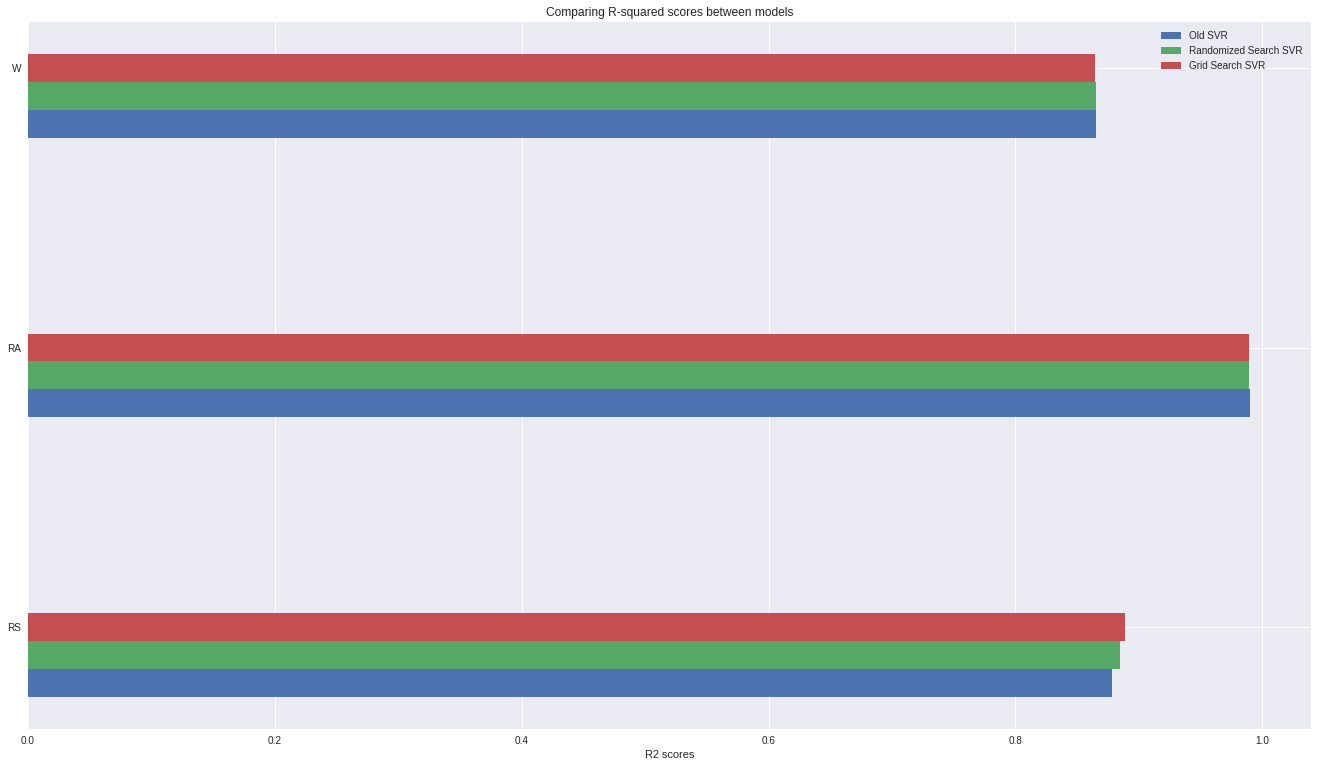

In [663]:
x_labels = ["RS","RA","W"]
# set distance between plots
N = 3
ind = np.arange(N)
width = 0.1
x = (ind)+(4*width)/2

plt.barh(ind,SVR2,width,label="Old SVR")
plt.barh(ind+width,svr_rand_R2,width,label="Randomized Search SVR")
plt.barh(ind+(2*width),svr_grid_R2,width,label="Grid Search SVR")
plt.yticks(x,x_labels)
plt.xlabel("R2 scores")
plt.legend()
plt.title("Comparing R-squared scores between models")
plt.show()

In [664]:
svr_comp = pd.DataFrame(index={"RS","RA","W"})
svr_comp["Old SVR (R2)"] = SVR2
svr_comp["Randomized Search (R2)"] = svr_rand_R2
svr_comp["Grid Search (R2)"] = svr_grid_R2
display(svr_comp)

,Old SVR (R2),Randomized Search (R2),Grid Search (R2)
RS,0.877907,0.884567,0.888597
RA,0.990392,0.988953,0.989105
W,0.865069,0.865533,0.864472


It appears that the hyperparameter tuning made very small improvements to the old SVR model, and in some cases underperformed. The Grid Search hyperparameter changes appear to have the biggest impact on the old SVR model with a positive impact on the RS R-squared score. On the other hand, the Grid Search produced a slight decrease in the R-squared score for RA & W, but RA & W displayed overfitting behavior in the old SVR model with either extremely high R-squared values (RA) or some fluctuation in the cross validation R-squared scores (W). Despite the slight overfitting, the old SVR model was already performing at a high R-squared score, so it makes sense that the hyperparameter tuning would not have a significant impact. We could try using the best SVR models when making predictions (i.e. Grid Search for RS, Randomized Search for W, and no changes for RA). 

## Making Predictions
Each dataframe compares the SVR predictions for RS, RA, and Wins to the actual RS, RA and Wins for the 2002 season as well as DePodesta's estimates. 

In [669]:
# RS 2002 data
XRS_2002 = post_2002[["OBP","SLG"]]
yRS_2002 = post_2002["RS"]

# RA 2002 data
XRA_2002 = post_2002[["OOBP","OSLG"]]
yRA_2002 = post_2002["RA"]

# W 2002 data
XRD_2002 = post_2002[["RD"]]
yW_2002 = post_2002["W"]

In [688]:
# RS
scRSX_2002,scRSy_2002,RSysc_2002 = scale_data(XRS_2002,yRS_2002)

# RA
scRAX_2002,scRAy_2002,RAysc_2002 = scale_data(XRA_2002,yRA_2002)
# W
scRDX_2002,scWy_2002,Wysc_2002 = scale_data(XRD_2002,yW_2002)

svrRS_gridpred_2002 = RSysc_2002.inverse_transform(svr_RS2_grid.predict(scRSX_2002))
svrRS_randpred_2002 = RSysc_2002.inverse_transform(svr_RS2_rand.predict(scRSX_2002))
old_svrRS_pred_2002 = RSysc_2002.inverse_transform(svr_RS.predict(scRSX_2002))

svrRA_randpred_2002 = RAysc_2002.inverse_transform(svr_RA2_rand.predict(scRAX_2002))
svrRA_gridpred_2002 = RAysc_2002.inverse_transform(svr_RA2_grid.predict(scRAX_2002))
old_svrRA_pred_2002 = RAysc_2002.inverse_transform(svr_RA.predict(scRAX_2002))

svrW_randpred_2002 = Wysc_2002.inverse_transform(svr_W2_rand.predict(scRDX_2002))
svrW_gridpred_2002 = Wysc_2002.inverse_transform(svr_W2_grid.predict(scRDX_2002))
old_svrW_pred_2002 = Wysc_2002.inverse_transform(svr_W.predict(scRDX_2002))

/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Runs Scored (RS)

In [689]:
# RS
svrRS_comp_2002 = pd.DataFrame({"Team":post_2002["Team"],'Actual':RSysc_2002.inverse_transform(scRSy_2002).ravel(),'SVR_Grid_RS':svrRS_gridpred_2002,"DePodesta":814,"Old_SVR":old_svrRS_pred_2002,"SVR_Rand_RS":svrRS_randpred_2002})
svrRS_comp_2002[svrRS_comp_2002["Team"]=="OAK"]

,Actual,DePodesta,Old_SVR,SVR_Grid_RS,SVR_Rand_RS,Team
320,800.0,814,800.030546,798.44168,800.476916,OAK


### Runs Allowed (RA)

In [690]:
# RA
svrRA_comp_2002 = pd.DataFrame({"Team":post_2002["Team"],'Actual':RAysc_2002.inverse_transform(scRAy_2002).ravel(),'SVR_Rand_RA':svrRA_randpred_2002,"DePodesta":645,"Old_SVR":old_svrRA_pred_2002,"SVR_Grid_RA":svrRA_gridpred_2002})
svrRA_comp_2002[svrRA_comp_2002["Team"]=="OAK"]

,Actual,DePodesta,Old_SVR,SVR_Grid_RA,SVR_Rand_RA,Team
320,654.0,645,640.998006,640.452628,640.290811,OAK


### Wins (W)

In [691]:
# W
svrW_comp_2002 = pd.DataFrame({'Team':post_2002["Team"],'Actual':Wysc_2002.inverse_transform(scWy_2002).ravel(),'SVR_Rand_W':svrW_randpred_2002,"DePodesta":99,"Old_SVR":old_svrW_pred_2002,"SVR_Grid_W":svrW_gridpred_2002})
svrW_comp_2002[svrW_comp_2002["Team"]=="OAK"]

,Actual,DePodesta,Old_SVR,SVR_Grid_W,SVR_Rand_W,Team
320,103.0,99,95.932016,95.801862,96.141521,OAK


We decided to try and compare the original SVR model to one of the two tuned SVR models to see if there was a signficant difference between the model predictions as a result of the changes in parameters. As the tables show, there was not a significant change in the predictions when using either model, but some models were slightly more accurate than others. It was a surprise to see that although the Grid Search improved the R-squared score for RS, the original model still produced a more accurate prediction for the Oakland A's RS stat for the 2002 season. On the other hand, the Random Search parameters for W produced a slightly more accurate prediction than the original SVR model which was expected from the improvement in the R-squared score. 

In regards to DePodesta's estimates, our SVR model outperformed his estimates in the RS category, but underperformed in the RA & W categories. Both of these categories displayed some overfitting behavior which could cause the predictions to be slightly off target due to catching "noise" in the data. We could not help having some overfitting in the RA category due to a large portion of the data having to be imputed. However, we could explore deeper into other baseball related stats that have a high correlation with the win ratio other than the run differential. Other improvements could be to try and find possible outliers in the data and more information regarding Sabermetrics and how the stats are calculated, in an effort to understand the relationships between the independent features in our dataset. Some multicollinearity could be causing some overlap between the independent variables which could produce more noise in our model. Lastly, we opted to not use multivariate linear regression model for making the predictions which was found to be the most accurate model out of the other regression models we created in this analysis. Perhaps using the multivariate linear regression model would produce more accurate predictions for this analysis...

## Predictions with Multivariate Linear Regression 

### Runs Scored (RS)

In [692]:
RSpred_2002 = regr_RS.predict(XRS_2002)
RScomp_2002 = pd.DataFrame({"Team":post_2002["Team"],"Actual_RS":yRS_2002,"Predicted_RS":RSpred_2002})
RScomp_2002[RScomp_2002["Team"]=="OAK"]

,Actual_RS,Predicted_RS,Team
320,800,805.381095,OAK


### Runs Allowed (RA)

In [693]:
RApred_2002 = regr_RA.predict(XRA_2002)
RAcomp_2002 = pd.DataFrame({"Team":post_2002["Team"],"Actual_RA":yRA_2002,"Predicted_RA":RApred_2002})
RAcomp_2002[RAcomp_2002["Team"]=="OAK"]

,Actual_RA,Predicted_RA,Team
320,654,636.834787,OAK


### Wins (W)

In [694]:
Wpred_2002 = regr_W.predict(XRD_2002)
Wcomp_2002 = pd.DataFrame({"Team":post_2002["Team"],"Actual_W":yW_2002,"Predicted_W":Wpred_2002})
Wcomp_2002[Wcomp_2002["Team"]=="OAK"]

,Actual_W,Predicted_W,Team
320,103,96.44086,OAK


It turns out that the SVR model made slightly more accurate predictions than the multivariate linear regression model. Therefore, to improve predictions in our future models we would need to either find the actual missing data for RA or research alternative baseball stats that correlate with RA. Furthermore, we could also find other stats that correlate with the win ratio that is independent from the run differential. The RS appears to be ok with our models because there is no overfitting present in our cross validation scores and the predictions are very close to the actual 2002 data. 

Overall, our models performed reasonably close to DePodesta's estimates and made predictions that were close to the actual 2002 stats for the Oakland A's team.

## Sources

1. https://en.wikipedia.org/wiki/Moneyball_(film)

2. https://en.wikipedia.org/wiki/Paul_DePodesta

3. https://en.wikipedia.org/wiki/Pythagorean_expectation

4. https://en.wikipedia.org/wiki/Major_League_Baseball_schedule

5. https://www.edx.org/course/analytics-edge-mitx-15-071x-3

6. https://en.wikipedia.org/wiki/Run_differential

7. https://www.kaggle.com/wduckett/moneyball-mlb-stats-19622012/home

8. https://en.wikipedia.org/wiki/On-base_percentage

9. https://en.wikipedia.org/wiki/Slugging_percentage

10. https://www.kaggle.com/wduckett/beane-and-depodesta-s-regression-roadmap